In [1]:
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
import cv2
import torch
import imageio
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torch
import torch.nn.functional as F

from tqdm.notebook import tqdm
from torch import Tensor
from itertools import compress, cycle
from collections import OrderedDict
from scipy.interpolate import griddata
from IPython.display import Image

from utils.utils import *

from utils.plotting import Plotter
from utils.gl_solver import GLSolver
from utils.parameters_init import ParametersInit
from utils.random_input_field import RandomInputField

import warnings
warnings.filterwarnings('ignore')

EPOCHS = 20_000
LR = 1
# SEED = 1234

# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)
# torch.set_default_tensor_type(torch.FloatTensor)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

myubatch_size = 32768

GETTING HANDS DIRTY WITH THE NEURAL NETWORKS

$$
\begin{aligned}
\partial_{t} A &= \mu A+\Delta A-|A|^{2} A
\end{aligned}
$$

In [3]:
class ALLINPUTNET(nn.Module):
    def __init__(self, layers_list, activation_function_list = None, linm = None):
        super(ALLINPUTNET, self).__init__()
        self._depth = len(layers_list) - 1
        
        if activation_function_list is None:
            activation_function_list = [F.softplus for _ in range(self._depth - 1)]
            
        if linm is None:
            linm =  np.tril(np.ones(self._depth + 1, dtype = int))
        lin = linm@layers_list
        
        self._activation_function_list = activation_function_list
        
        self._Wtmx = nn.Sequential(*[torch.nn.Linear(lin[i], layers_list[i+1], dtype = torch.float64) for i in range(self._depth)])
        self._linm = linm
        
        self.optimizer = torch.optim.Adam( params = self._Wtmx.parameters(), lr=0.01 )    
        
    def forward(self, x):
        layers = [x,self._Wtmx[0](x)]
        for i in range(1, self._depth):
            layers[i] = self._activation_function_list[i-1](layers[i])
            ind = self._linm[i]
            inpind = np.where(ind)[0]
            inp = torch.concat([layers[i] for i in inpind], dim = -1)
            layers.append(self._Wtmx[i](inp))
        return layers[-1]        

    def predict(self, x):
        self._Wtmx.eval()
        if type(x) is not torch.Tensor:
            x = torch.tensor(x, dtype = torch.float64).to(device)
        y =  self.forward(x).cpu().detach().numpy()
        return y[:,0] + y[:,1]*1j    

    def rmsef(self, y, y_pred):
        mseloss = torch.sum((y_pred - y)**2, dim = 1)
        return torch.mean(torch.sqrt(mseloss))   

    def msef(self, y, y_pred):
        return torch.mean((y_pred - y)**2)       

    def fastmsebatchtrain(self, x, y, epochs=100, batch_size = 64):
        
        x = torch.tensor(x, dtype = torch.float64).to(device)
        y = torch.tensor(y, dtype = torch.float64).to(device)
        dataloader = DataLoader(dataset = torch.hstack((x,y)), batch_size=batch_size, shuffle=True)
        
        self.optimizer.zero_grad()
        L = []
        
        pbar = tqdm(total=epochs)
        try:
            while True:
                if pbar.n >= epochs:
                    break
                for tmp in dataloader:
                    (tmpx, tmpy, tmpt, tmpu_real, tmpu_img) = tmp.T
                    X = torch.stack((tmpx,tmpy,tmpt)).T
                    U = torch.stack((tmpu_real, tmpu_img)).T

                    y_pred = self.forward(X)
                    loss = self.msef(y_pred,U)
                    L.append(loss.cpu().detach().numpy())
                    loss.backward()
                    self.optimizer.step()
                    self._Wtmx.zero_grad()
                    self.optimizer.zero_grad()
                    # Update the progress bar
                    if pbar.n >= epochs:
                        break
                    pbar.update(1)
                        
        except Exception as e:
            raise Exception(e)
        finally:
            # Close the progress bar
            pbar.close()          
        return L
    
    def fastrmsebatchtrain(self, x, y, epochs=100, batch_size = 64):
        
        x = torch.tensor(x, dtype = torch.float64).to(device)
        y = torch.tensor(y, dtype = torch.float64).to(device)
        dataloader = DataLoader(dataset = torch.hstack((x,y)), batch_size=batch_size, shuffle=True)
        
        self.optimizer.zero_grad()
        L = []
        
        pbar = tqdm(total=epochs)
        try:
            while True:
                if pbar.n >= epochs:
                    break
                for tmp in dataloader:
                    (tmpx, tmpy, tmpt, tmpu_real, tmpu_img) = tmp.T
                    X = torch.stack((tmpx,tmpy,tmpt)).T
                    U = torch.stack((tmpu_real, tmpu_img)).T

                    y_pred = self.forward(X)
                    loss = self.rmsef(y_pred,U)
                    L.append(loss.cpu().detach().numpy())
                    loss.backward()
                    self.optimizer.step()
                    self._Wtmx.zero_grad()
                    self.optimizer.zero_grad()
                    # Update the progress bar
                    if pbar.n >= epochs:
                        break
                    pbar.update(1)
                        
        except Exception as e:
            raise Exception(e)
        finally:
            # Close the progress bar
            pbar.close()          
        return L

In [4]:
class ALLINPUTPINN(ALLINPUTNET):
    def __init__(self,*args,**kwargs):
        super(ALLINPUTPINN, self).__init__(*args,**kwargs)
#         myu = torch.randn(4, 2, dtype=torch.float64).to(device)
#         myu = nn.Parameter(myu)
#         self._Wtmx.register_parameter('myu', myu)
#         self.myuparam = myu
#         myu = transform_and_stack(myu, 4, 200).to(device).clone().requires_grad_(True)
#         self.myu = myu.view(200, 4, 4)
        self.myureset()
    
    def myureset(self):
        myu = torch.randn(mem_rate, Nx//input_to_defect_ratio_sqrt, Ny//input_to_defect_ratio_sqrt, dtype=torch.float64).to(device)
        myu = nn.Parameter(myu)
        self.myuparam = myu
        self._Wtmx.register_parameter('myu', myu)
        
    @property
    def myu(self):
        myu = F.interpolate(self.myuparam.unsqueeze(0), scale_factor=input_to_defect_ratio_sqrt, mode='nearest').squeeze()
        return myu
    
    def loaddata_precalculate(self,x):
        myuloss = MYULOSS(*tuple(x.T),self)
        myuloss.calculate_f_withoutmyu()
        self.myuloss = myuloss
    
    def fmsef(self, myu):
        return self.myuloss.fmse(myu)
    
    def fmse(self):
        return self.fmsef(self.myu)
    
    def myutrain(self, epochs=100, lr = 0.01):
        
        myuoptimizer = torch.optim.Adam( params = [self.myuparam], lr=lr ) 
        myuoptimizer.zero_grad()

        for _ in tqdm(range(epochs)):
            self.fmse().backward(retain_graph=True)
            myuoptimizer.step()
            myuoptimizer.zero_grad()
        
        FMSE = self.myuloss.FMSE
        self.myuloss.clear()
        return FMSE

In [5]:
class MYULOSS:
  def __init__(self, x, y, t, net, verbose = 0):
      self.msef = nn.MSELoss()
      self.FMSE = []
      self.x = x
      self.y = y
      self.t = t
      self.net = net
        
  def plot(self, title= 'MYU training'):
    plt.plot(self.FMSE)
    plt.yscale('log')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('FMSE')
    self.clear()
    
  def clear(self):
    self.FMSE = []
    
  def fmse(self, myu):
    f_loss = torch.mean(torch.abs(self.net_f(myu)) ** 2)
    self.FMSE.append(f_loss.cpu().detach().numpy())
    return f_loss
  
  def net_f(self, myu, verbose = 0):
        return self.f_withoutmyu - myu*self.u 
    
  def calculate_f_withoutmyu(self):
        x,y,t = self.x, self.y, self.t
        
        u, u_t,u_xx,u_yy = MYULOSS.pref(x,y,t,net)
        
        self.u = u.cpu().detach()
            
        f_withoutmyu = u_t - (u_xx + u_yy) + torch.pow(torch.abs(u), 2)*u #- myu*u
        self.f_withoutmyu = f_withoutmyu.cpu().detach()
        free_memory(u_t, u_xx, u_yy, u, f_withoutmyu)

    
  def f_withoutmyu(x,y,t,ru,iu):
        (ru_t, ru_x, ru_y) = torch.autograd.grad(ru, (t, x, y), grad_outputs=torch.ones_like(ru), create_graph=True, retain_graph=True)
        (iu_t, iu_x, iu_y) = torch.autograd.grad(iu, (t, x, y), grad_outputs=torch.ones_like(iu), create_graph=True, retain_graph=True)

        (ru_xx,) = torch.autograd.grad(ru_x, (x), grad_outputs=torch.ones_like(ru_x), create_graph=True)
        (iu_xx,) = torch.autograd.grad(iu_x, (x), grad_outputs=torch.ones_like(iu_x), create_graph=True)

        (ru_yy,) = torch.autograd.grad(ru_y, (y), grad_outputs=torch.ones_like(ru_y), create_graph=True)
        (iu_yy,) = torch.autograd.grad(iu_y, (y), grad_outputs=torch.ones_like(iu_y), create_graph=True)

        u =( ru + iu * 1j)
        u_t = (ru_t + iu_t * 1j)
        u_xx =( ru_xx + iu_xx *1j)
        u_yy = (ru_yy + iu_yy *1j)
        
        return u, u_t,u_xx,u_yy
    
  def pref(x,y,t, net, batch_size = myubatch_size):
    dataloader = DataLoader(dataset = X_star, batch_size = batch_size, shuffle=False)
    cache = {
        'u':[],
        'u_t':[],
        'u_xx':[],
        'u_yy':[],
    }
    for tmp in tqdm(dataloader):
        x,y,t = torch.tensor(tmp.T, dtype = torch.float64, requires_grad=True).to(device)
        ru,iu = net.forward(torch.stack((x,y,t)).T).T
        u, u_t,u_xx,u_yy = MYULOSS.f_withoutmyu(x,y,t,ru,iu)
        cache['u'].append(u.cpu().detach())
        cache['u_t'].append(u_t.cpu().detach())
        cache['u_xx'].append(u_xx.cpu().detach())
        cache['u_yy'].append(u_yy.cpu().detach())
        
    return  torch.cat(cache['u']).view(mem_rate, Nx, Ny), \
            torch.cat(cache['u_t']).view(mem_rate, Nx, Ny),\
            torch.cat(cache['u_xx']).view(mem_rate, Nx, Ny),\
            torch.cat(cache['u_yy']).view(mem_rate, Nx, Ny)

      
def free_memory(*variables):
    del variables
    torch.cuda.empty_cache()

In [6]:
def train():
    L1 = net.fastrmsebatchtrain(x = X_star, y = u_star, epochs = 100000)

    plt.plot(L1)
    plt.yscale('log')
    plt.xlabel('epochs')
    plt.ylabel('Custom Loss')
    plt.title('Training of the AllInputNet \n lr=0.01')
    plt.savefig(f'{mtlibpath_prefix}_allinputnet001.png')
    plt.show()

    net.optimizer.param_groups[0]['lr'] = 0.001
    L2 = net.fastrmsebatchtrain(x = X_star, y = u_star, epochs = 100000)

    plt.plot(L2)
    plt.yscale('log')
    plt.xlabel('epochs')
    plt.ylabel('Custom Loss')
    plt.title('Training of the AllInputNet \n lr=0.001')
    plt.savefig(f'{mtlibpath_prefix}_allinputnet0001.png')
    plt.show()

## calculating myus

In [7]:
def myutrain():
    global device
    global net
    torch.cuda.empty_cache()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    net.loaddata_precalculate(X_star)
    net.myureset()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net = net.to(device)
    net.myureset()

    i = 0
    for lr in [10, 3, 1, 0.3]:
        L = net.myutrain(lr=lr, epochs=10)
        l = net.fmse().cpu().detach().numpy()
        L += [l]
        net.myuloss.clear()

        plt.plot(range(i,i+len(L)), L, label=f'lr={lr}')
        i+=len(L)-1

    plt.yscale('log')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('FMSE')
    plt.title('MYU Training')
    plt.tight_layout()
    plt.savefig(f'{mtlibpath_prefix}_myutraining.png')
    plt.show()

## Visualizing and saving plot gifs

In [8]:
def plot():
    ploter = Plotter(net.myu.cpu().detach().numpy())
    ploter.output_animation(mem_rate, save_gif=True, file_name=rf"{path}_myupred.gif")
    plt.show()
    ploter = Plotter(myu_original.squeeze(0))
    ploter.output_animation(mem_rate, save_gif=True, file_name=rf"{path}_myuorig.gif")
    plt.show()

    create_gifs(
        memory_rate=mem_rate,
        u_pred=net.predict(X_star),
        original=A_original,
        save=True,
        path_for_gif=path+".gif",
        duration=500,
        title=" "
    )
    Image(filename=path+".gif")
    gif = imageio.mimread(path+".gif", memtest=False)
    nums = len(gif)
    print("Total {} frames in the gif {}!".format(nums, path+".gif"))
    

In [9]:
!mkdir -p full_analysis
import pandas as pd
df = pd.DataFrame({"key":[],"N":[],"L":[],"mse":[],"rmse":[], "fmse": []})

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8050.49it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [400 400 400 400 400 400 400 400]
A.shape=(1, 200, 4, 4),
Myu.shape=(1, 200, 4, 4),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:32<00:00, 1086.67it/s]


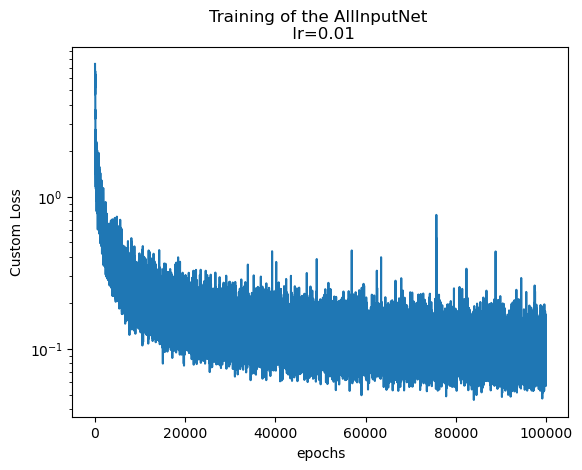

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:36<00:00, 1040.24it/s]


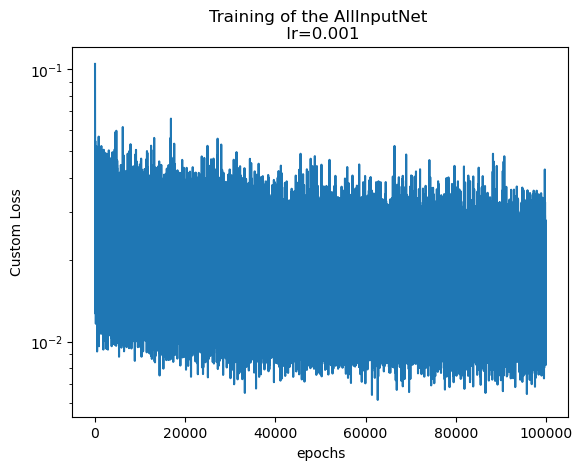

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1103.47it/s]


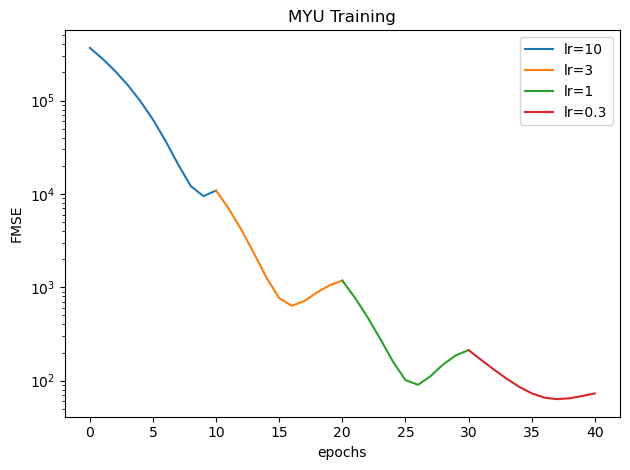

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

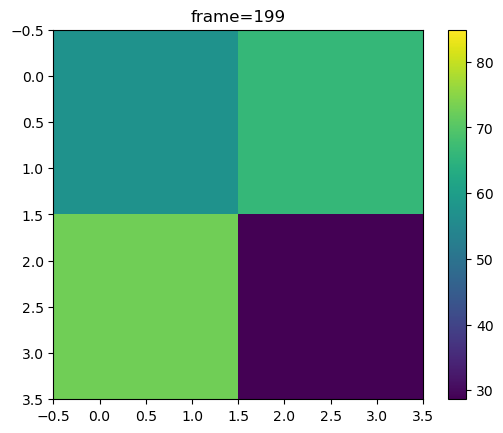

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

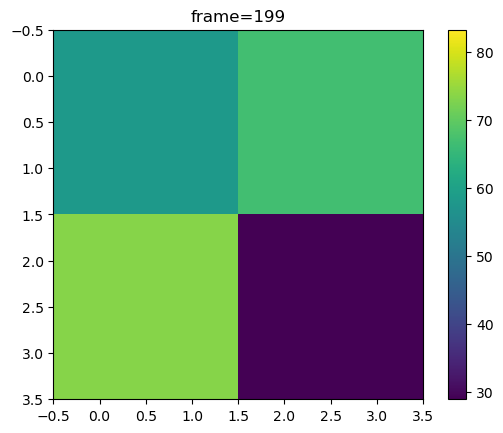

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.08it/s]


GIF successfully saved at full_analysis/allinputnet-N=4L=17-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=4L=17-test2-origin.gif!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 9871.62it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [400 400 400 400 400 400 400 400]
A.shape=(1, 200, 4, 4),
Myu.shape=(1, 200, 4, 4),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:35<00:00, 1042.27it/s]


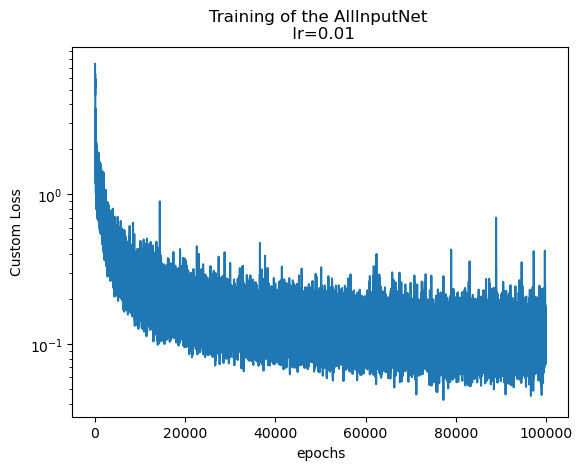

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:32<00:00, 1076.95it/s]


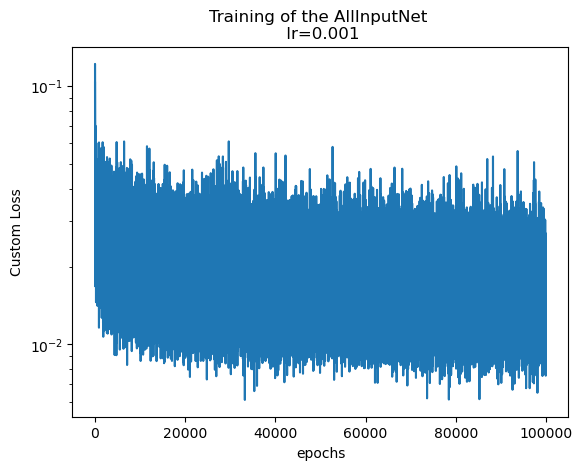

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3032.10it/s]


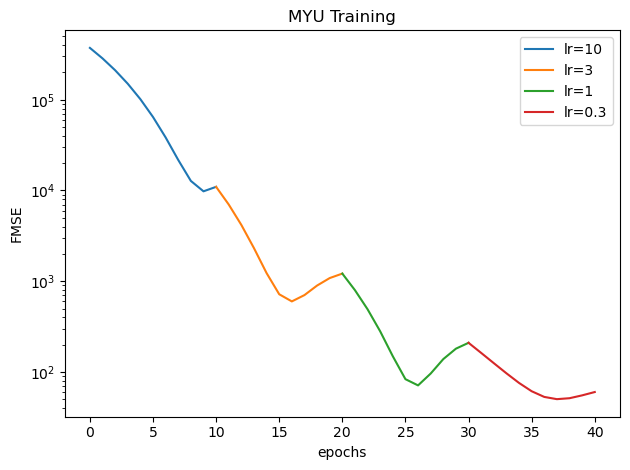

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

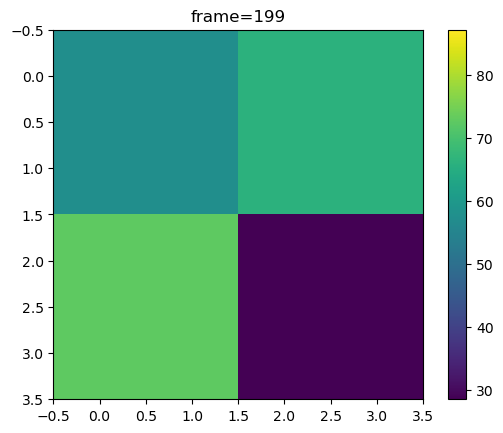

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

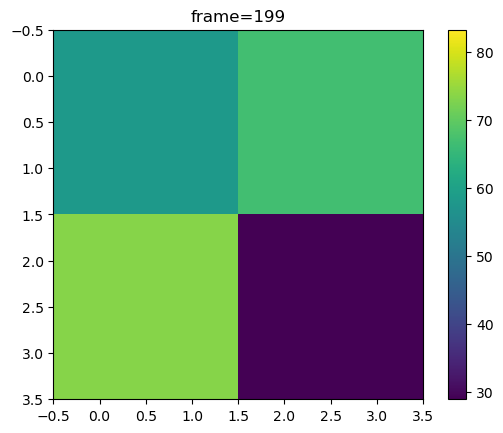

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 20.78it/s]


GIF successfully saved at full_analysis/allinputnet-N=4L=22-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=4L=22-test2-origin.gif!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8054.82it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [900 900 900 900 900 900 900 900]
A.shape=(1, 200, 6, 6),
Myu.shape=(1, 200, 6, 6),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:42<00:00, 977.37it/s]


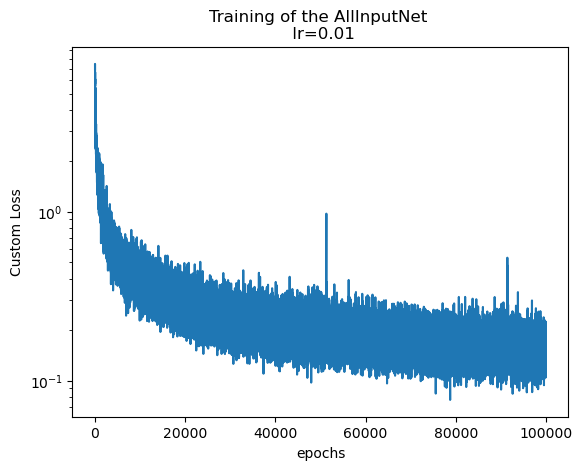

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:38<00:00, 1015.66it/s]


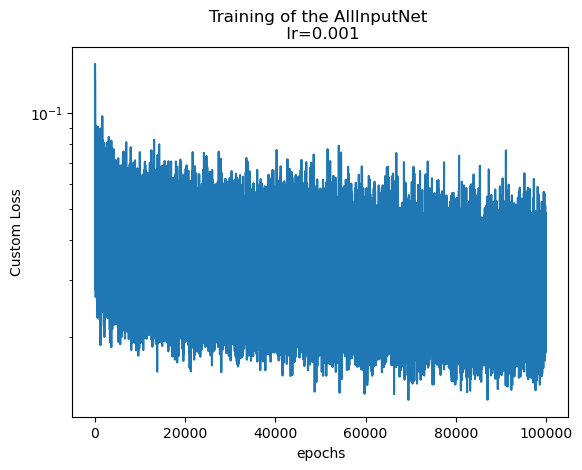

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2744.24it/s]


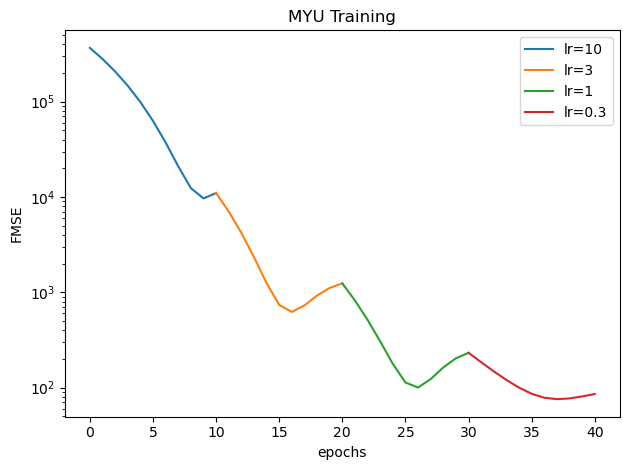

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

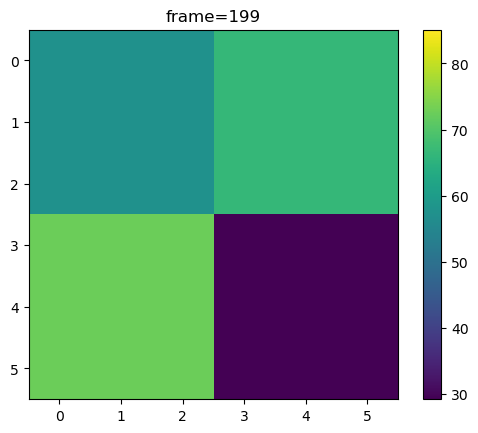

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

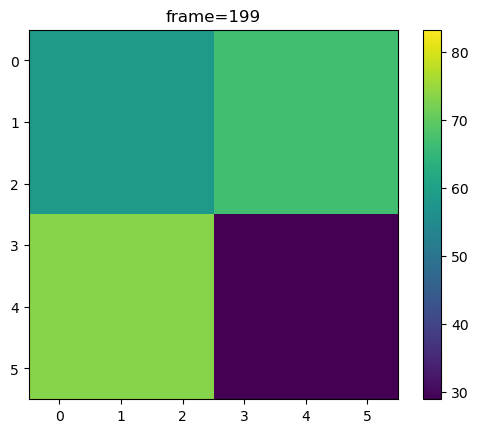

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 22.65it/s]


GIF successfully saved at full_analysis/allinputnet-N=6L=17-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=6L=17-test2-origin.gif!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 11519.49it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [900 900 900 900 900 900 900 900]
A.shape=(1, 200, 6, 6),
Myu.shape=(1, 200, 6, 6),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:30<00:00, 1106.89it/s]


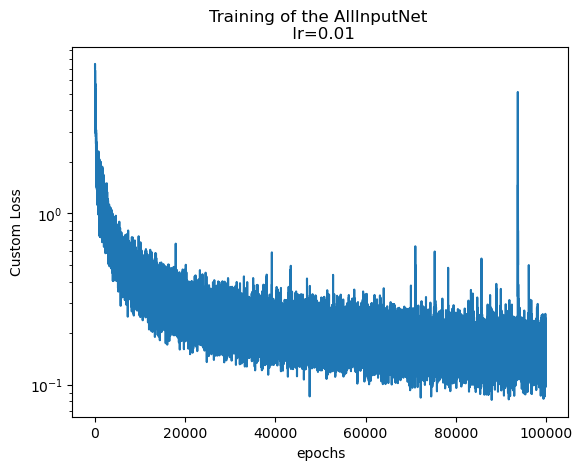

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:29<00:00, 1112.91it/s]


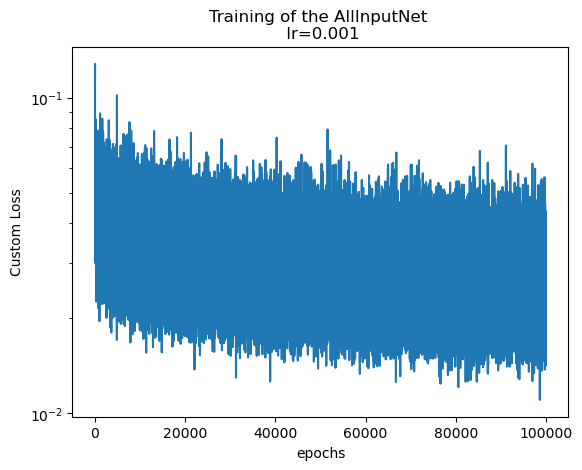

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2824.07it/s]


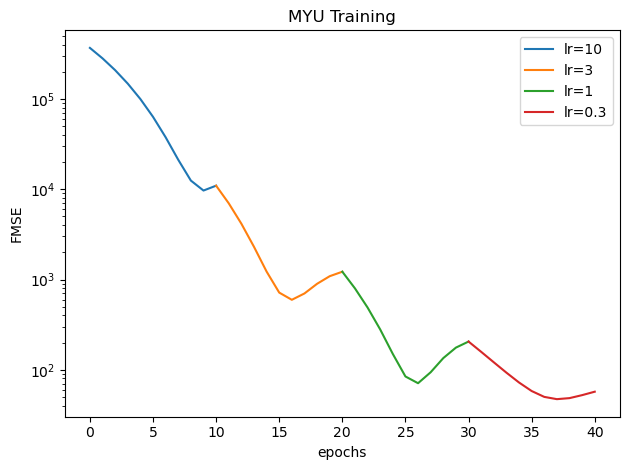

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

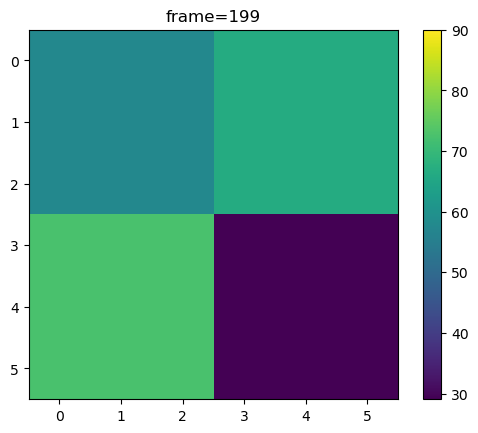

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

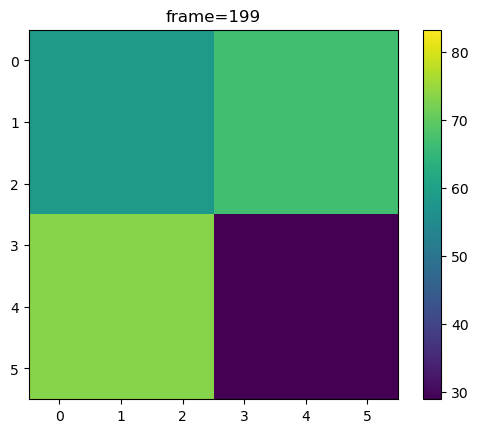

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 22.61it/s]


GIF successfully saved at full_analysis/allinputnet-N=6L=22-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=6L=22-test2-origin.gif!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 9301.35it/s]

Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [1600 1600 1600 1600 1600 1600 1600 1600]
A.shape=(1, 200, 8, 8),
Myu.shape=(1, 200, 8, 8),

Any NaN values in Myu		 False
Any NaN values in A_original	 False



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:32<00:00, 1086.22it/s]


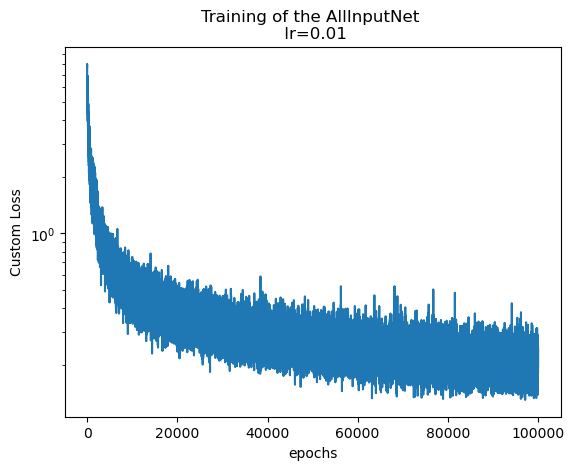

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:35<00:00, 1048.35it/s]


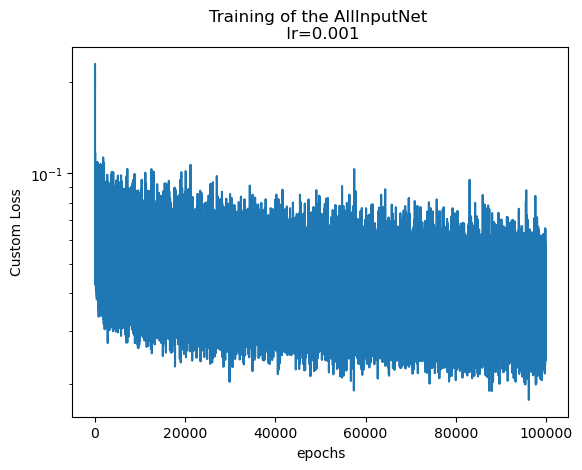

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 808.42it/s]


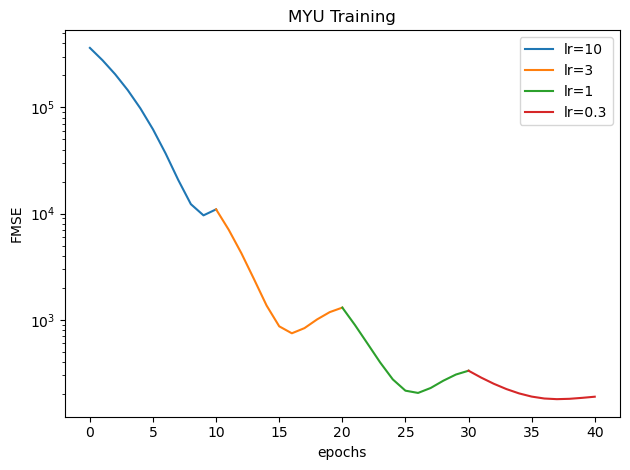

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

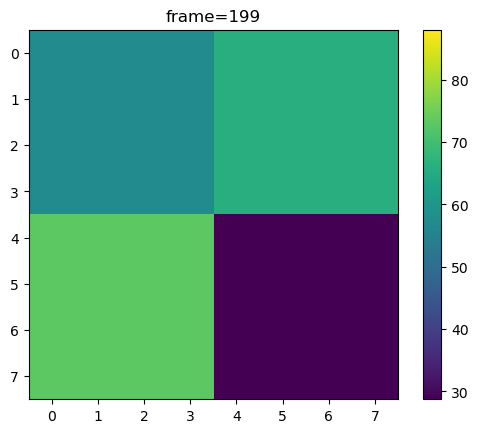

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

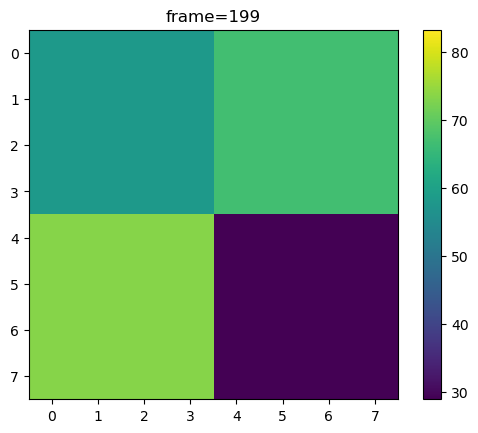

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.37it/s]


GIF successfully saved at full_analysis/allinputnet-N=8L=17-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=8L=17-test2-origin.gif!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4680.88it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [1600 1600 1600 1600 1600 1600 1600 1600]
A.shape=(1, 200, 8, 8),
Myu.shape=(1, 200, 8, 8),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:37<00:00, 1028.54it/s]


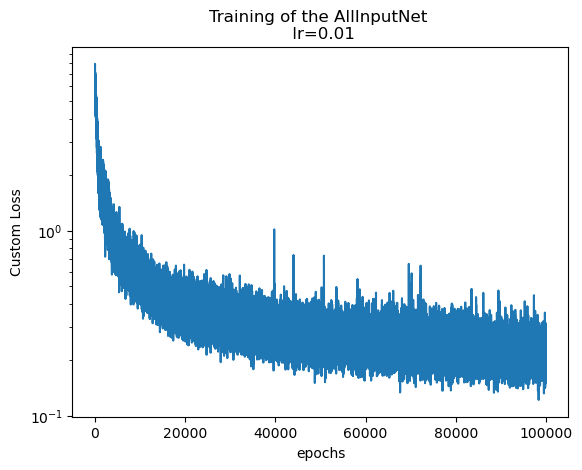

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:33<00:00, 1068.26it/s]


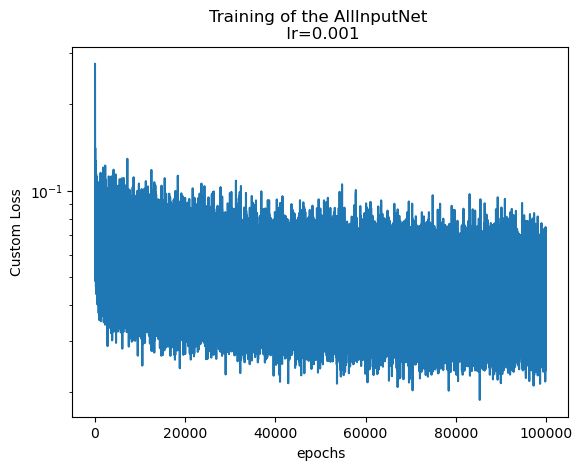

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1096.38it/s]


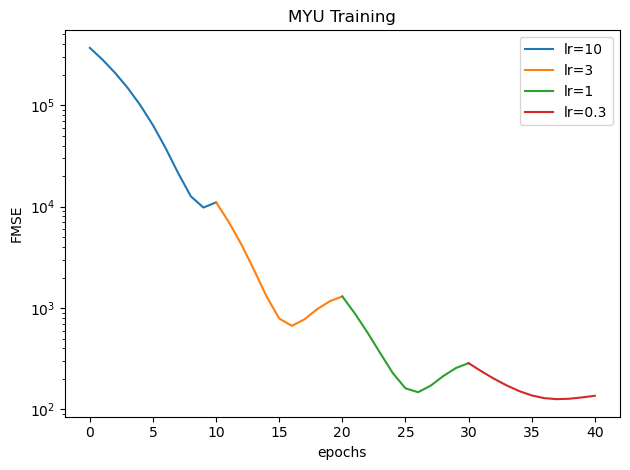

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

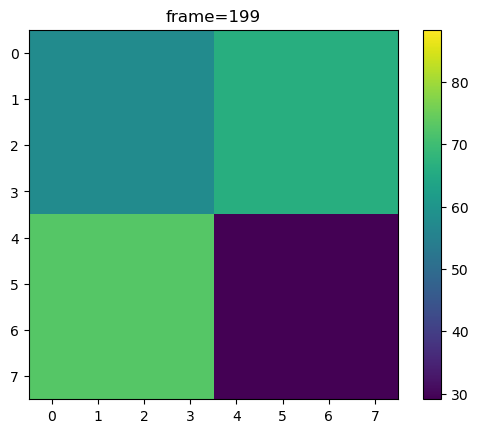

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

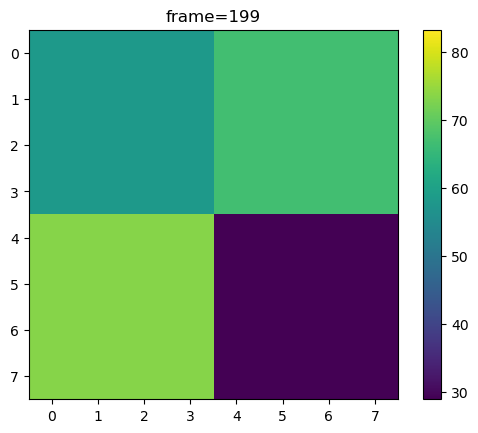

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.40it/s]


GIF successfully saved at full_analysis/allinputnet-N=8L=22-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=8L=22-test2-origin.gif!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2731.76it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [2500 2500 2500 2500 2500 2500 2500 2500]
A.shape=(1, 200, 10, 10),
Myu.shape=(1, 200, 10, 10),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:38<00:00, 1019.20it/s]


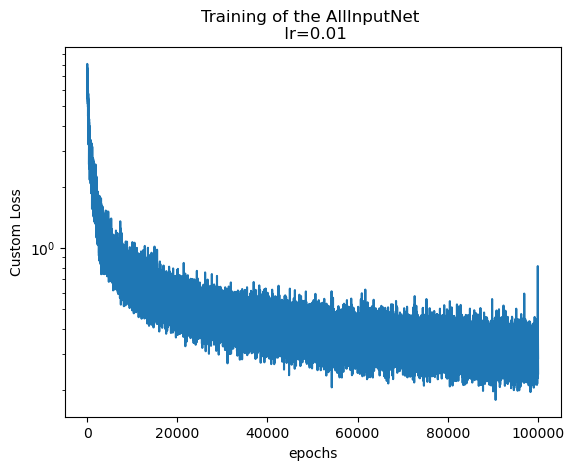

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:32<00:00, 1082.75it/s]


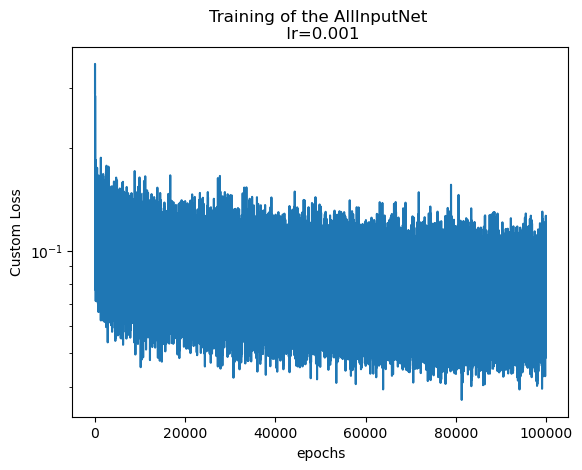

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1965.74it/s]


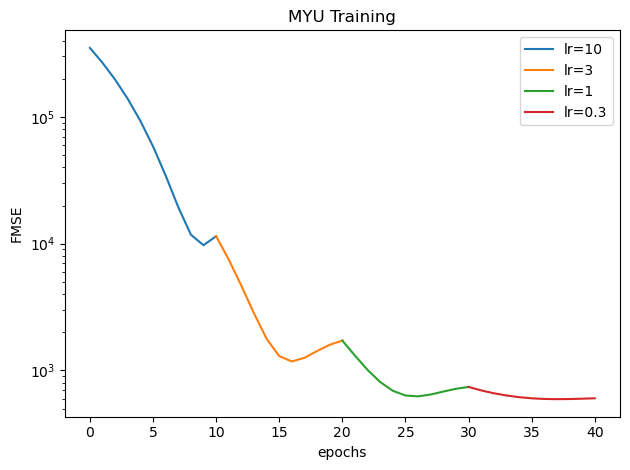

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

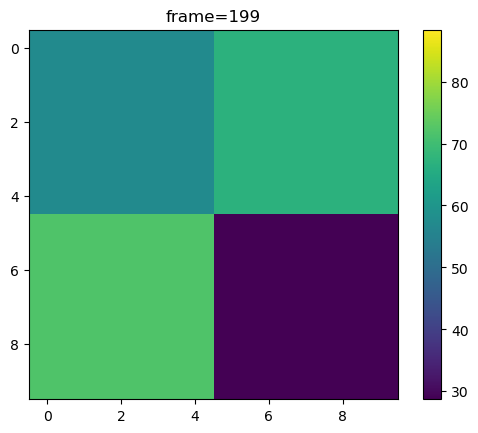

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

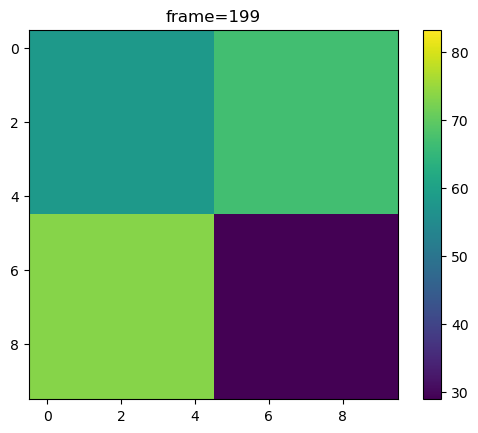

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.40it/s]


GIF successfully saved at full_analysis/allinputnet-N=10L=17-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=10L=17-test2-origin.gif!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4195.33it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [2500 2500 2500 2500 2500 2500 2500 2500]
A.shape=(1, 200, 10, 10),
Myu.shape=(1, 200, 10, 10),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:31<00:00, 1098.32it/s]


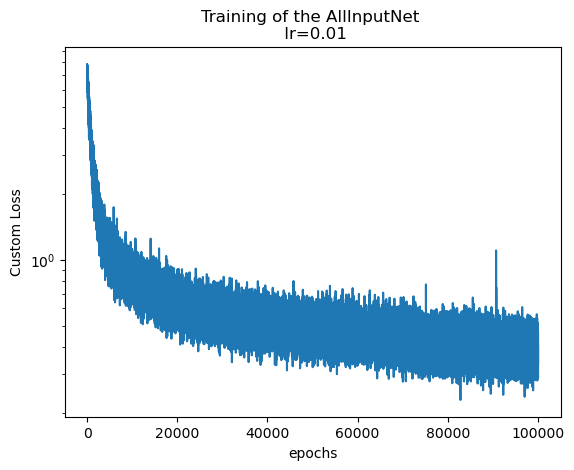

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:32<00:00, 1079.47it/s]


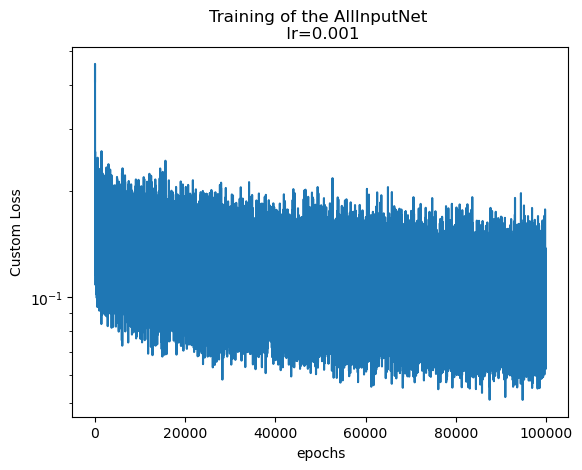

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1778.38it/s]


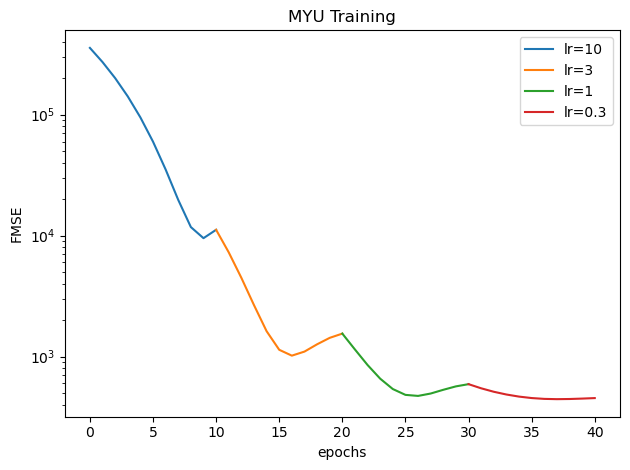

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

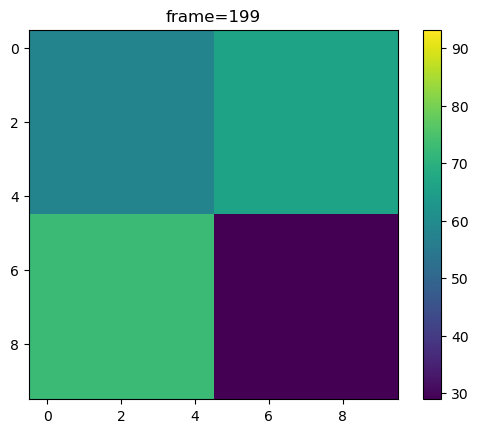

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

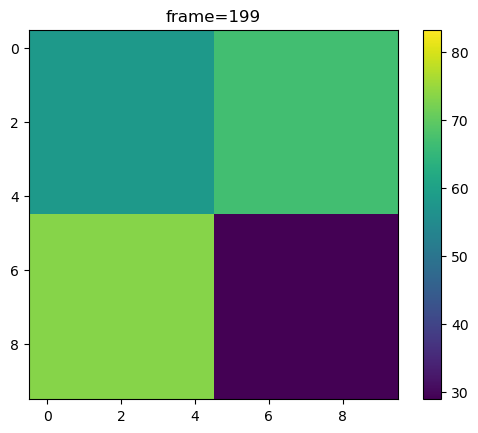

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 23.61it/s]


GIF successfully saved at full_analysis/allinputnet-N=10L=22-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=10L=22-test2-origin.gif!


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 10087.07it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [3600 3600 3600 3600 3600 3600 3600 3600]
A.shape=(1, 200, 12, 12),
Myu.shape=(1, 200, 12, 12),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:29<00:00, 1116.06it/s]


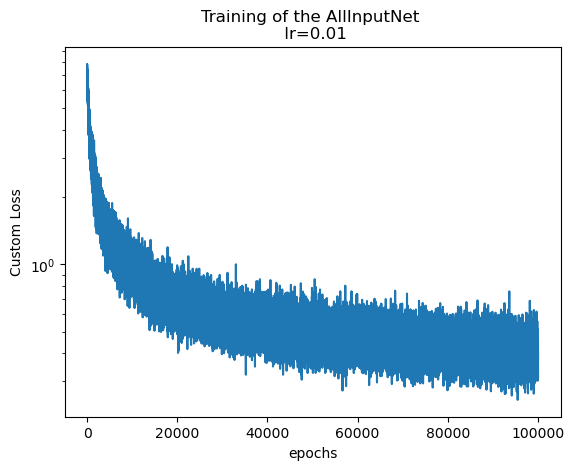

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:29<00:00, 1121.96it/s]


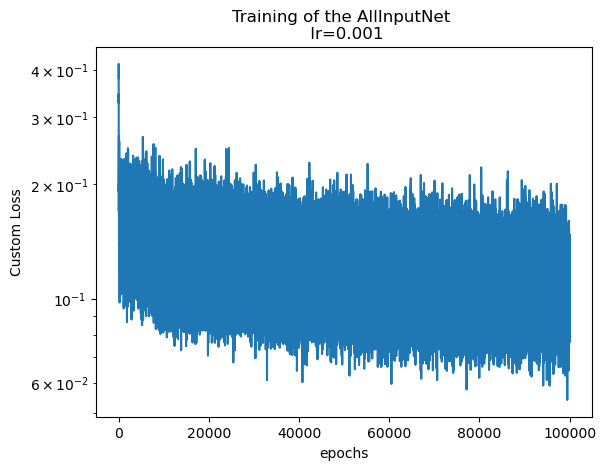

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1068.69it/s]


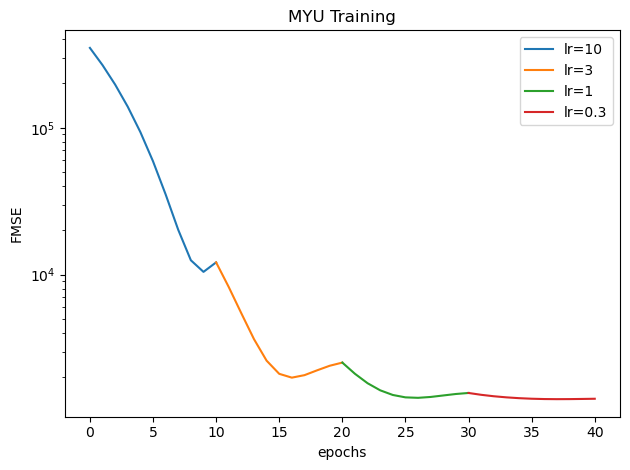

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

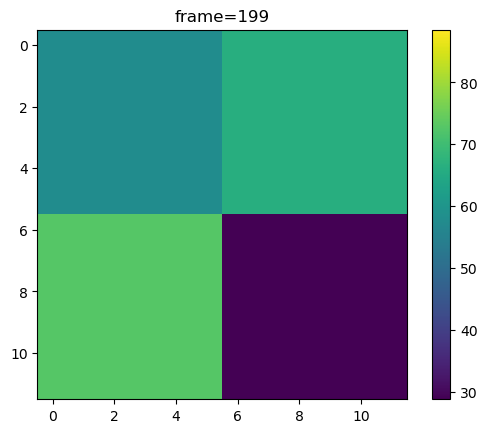

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

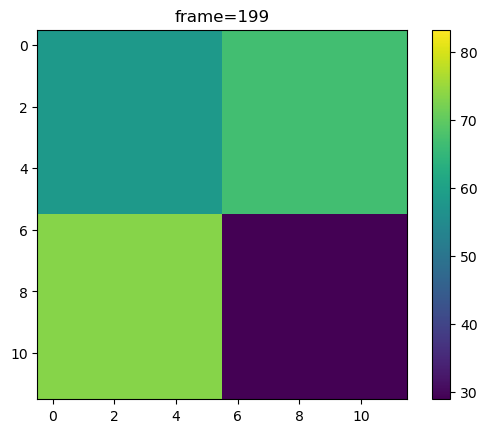

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 22.72it/s]


GIF successfully saved at full_analysis/allinputnet-N=12L=17-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=12L=17-test2-origin.gif!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2777.31it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [3600 3600 3600 3600 3600 3600 3600 3600]
A.shape=(1, 200, 12, 12),
Myu.shape=(1, 200, 12, 12),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:35<00:00, 1051.93it/s]


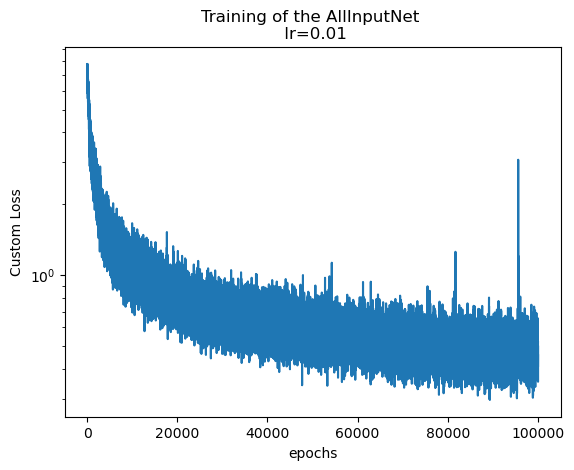

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:31<00:00, 1090.82it/s]


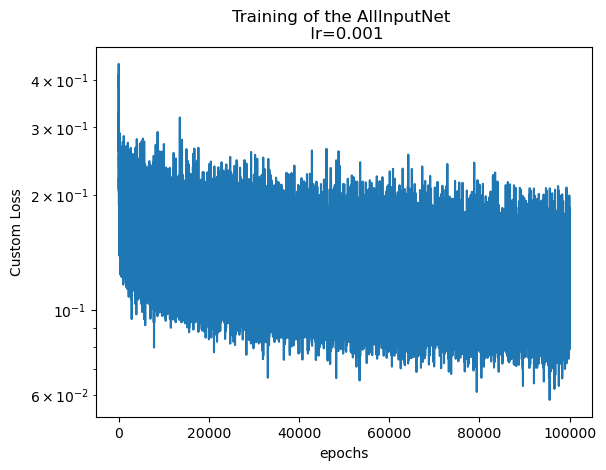

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1642.51it/s]


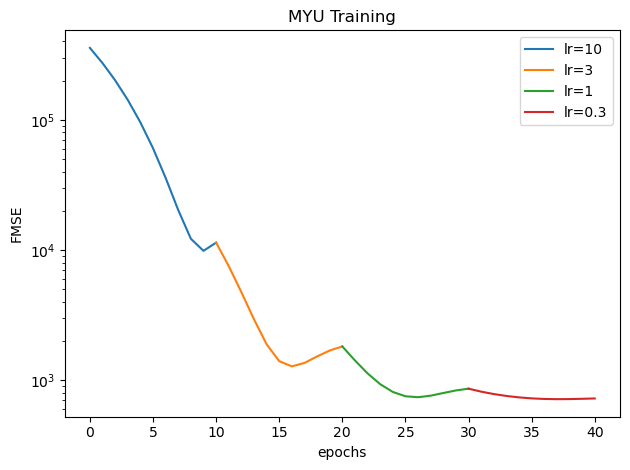

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

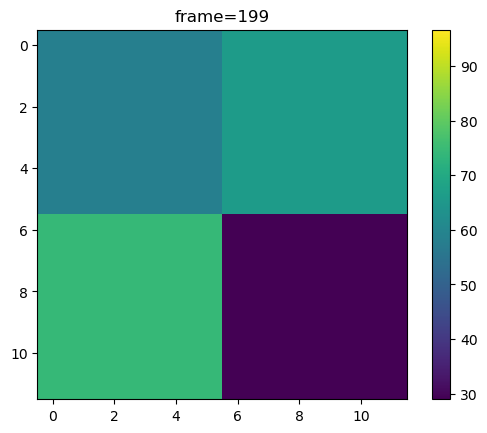

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

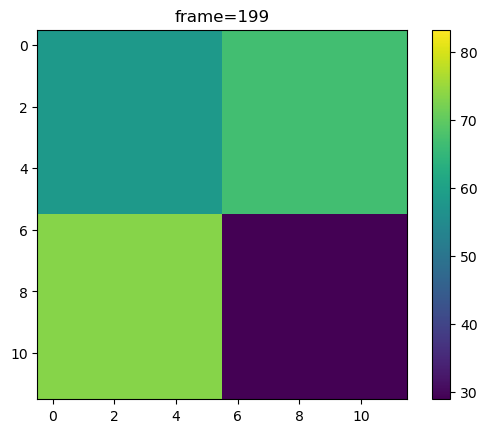

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 22.74it/s]


GIF successfully saved at full_analysis/allinputnet-N=12L=22-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=12L=22-test2-origin.gif!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6527.39it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [4900 4900 4900 4900 4900 4900 4900 4900]
A.shape=(1, 200, 14, 14),
Myu.shape=(1, 200, 14, 14),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:31<00:00, 1097.82it/s]


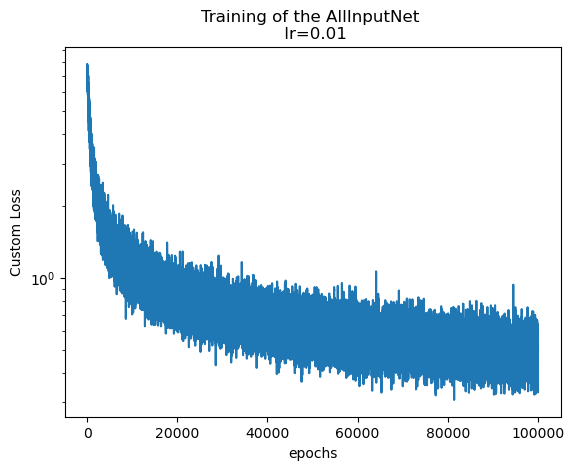

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:33<00:00, 1069.66it/s]


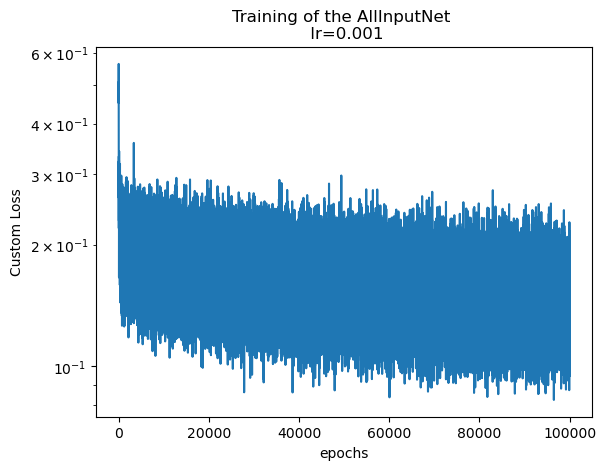

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1342.44it/s]


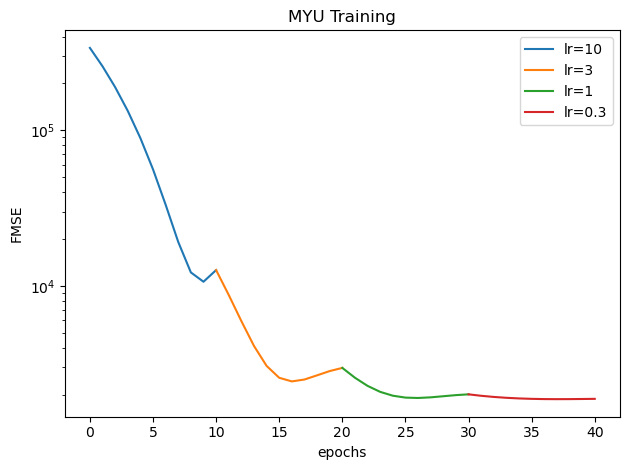

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

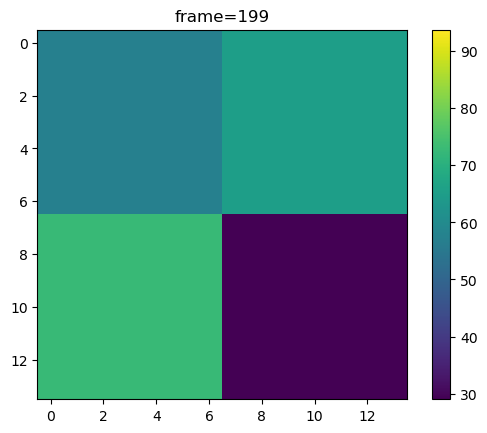

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

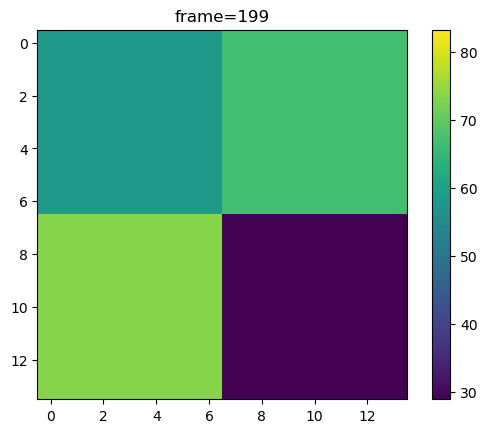

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.88it/s]


GIF successfully saved at full_analysis/allinputnet-N=14L=17-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=14L=17-test2-origin.gif!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 6077.38it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [4900 4900 4900 4900 4900 4900 4900 4900]
A.shape=(1, 200, 14, 14),
Myu.shape=(1, 200, 14, 14),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:35<00:00, 1049.79it/s]


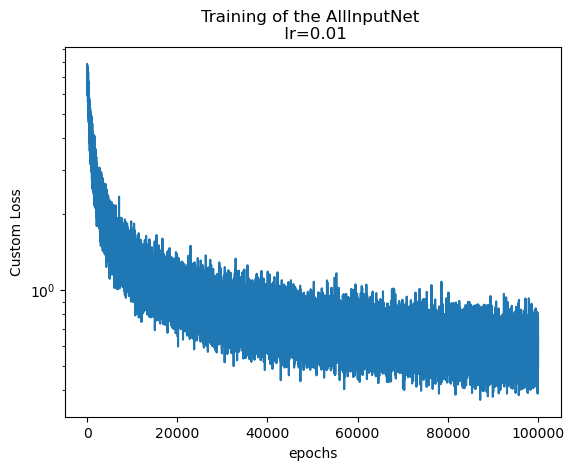

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:44<00:00, 954.70it/s]


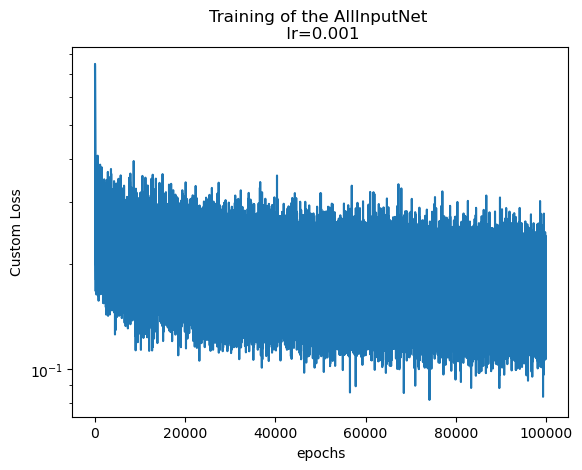

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1084.14it/s]


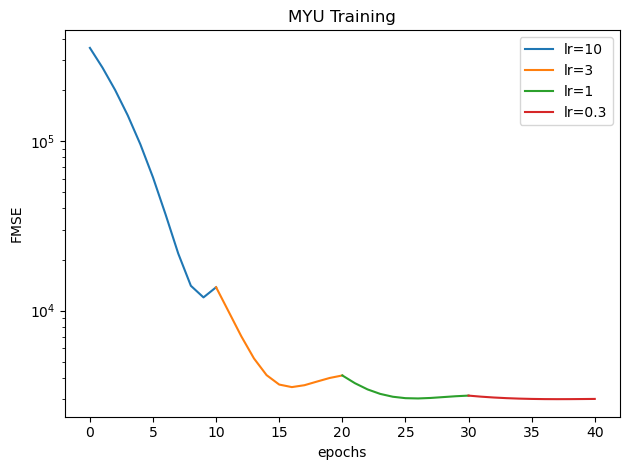

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

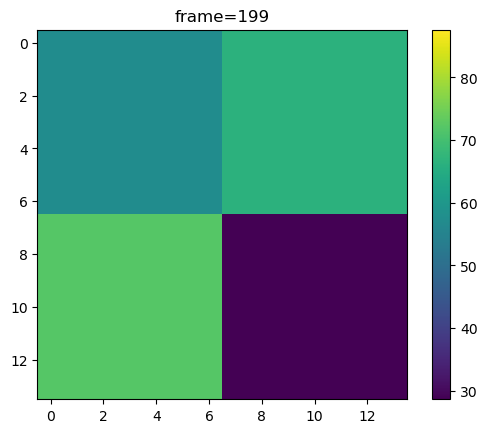

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

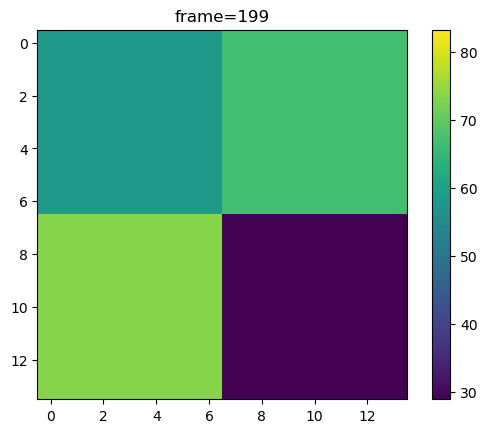

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:08<00:00, 22.34it/s]


GIF successfully saved at full_analysis/allinputnet-N=14L=22-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=14L=22-test2-origin.gif!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 8160.28it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [6400 6400 6400 6400 6400 6400 6400 6400]
A.shape=(1, 200, 16, 16),
Myu.shape=(1, 200, 16, 16),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:30<00:00, 1104.18it/s]


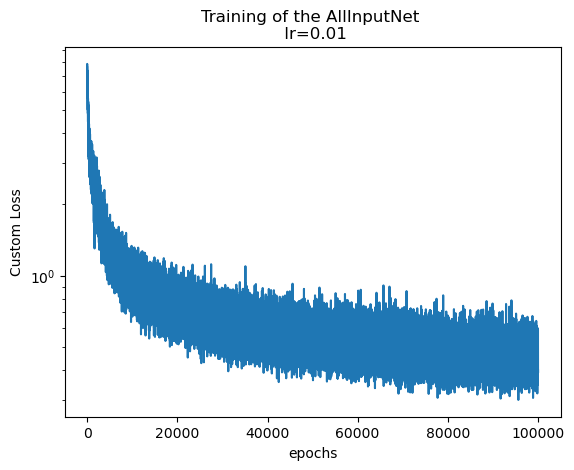

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:32<00:00, 1077.26it/s]


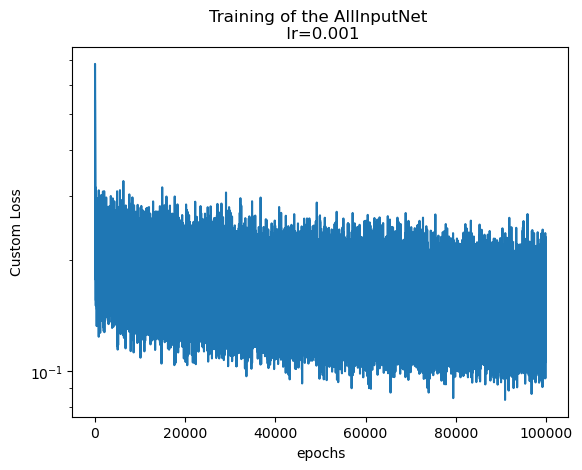

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1305.82it/s]


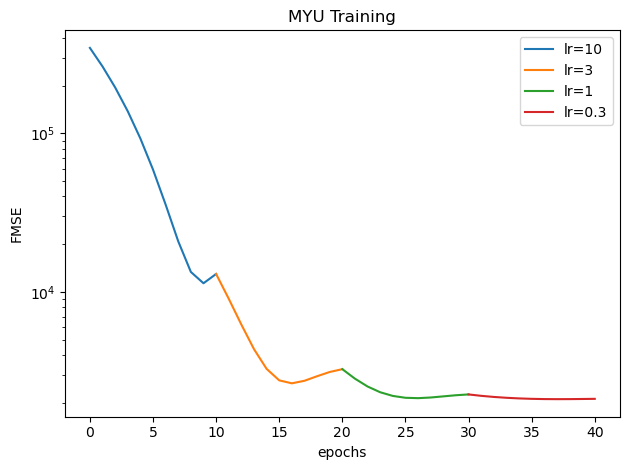

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

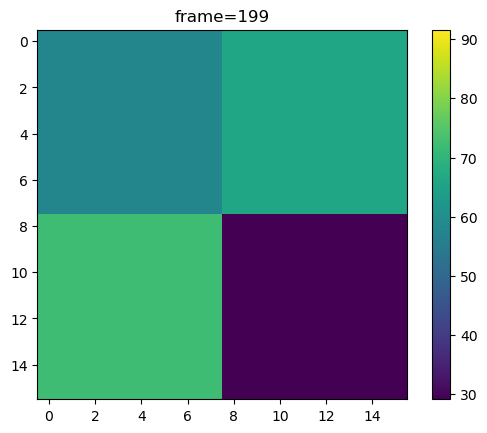

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

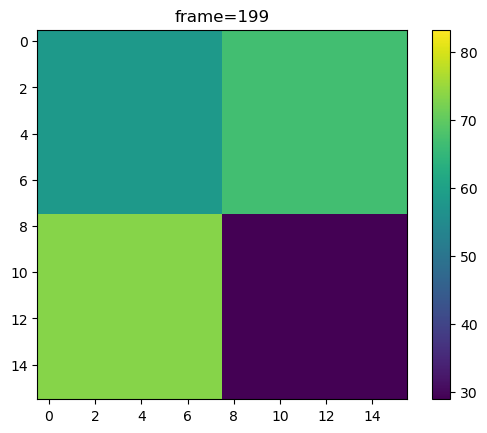

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 20.74it/s]


GIF successfully saved at full_analysis/allinputnet-N=16L=17-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=16L=17-test2-origin.gif!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 7692.87it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [6400 6400 6400 6400 6400 6400 6400 6400]
A.shape=(1, 200, 16, 16),
Myu.shape=(1, 200, 16, 16),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:29<00:00, 1118.08it/s]


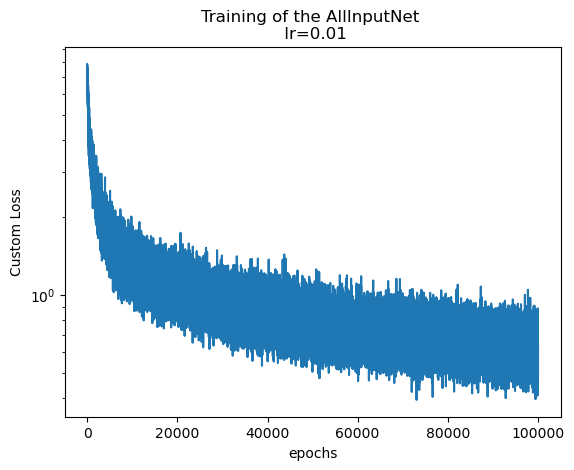

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:31<00:00, 1089.22it/s]


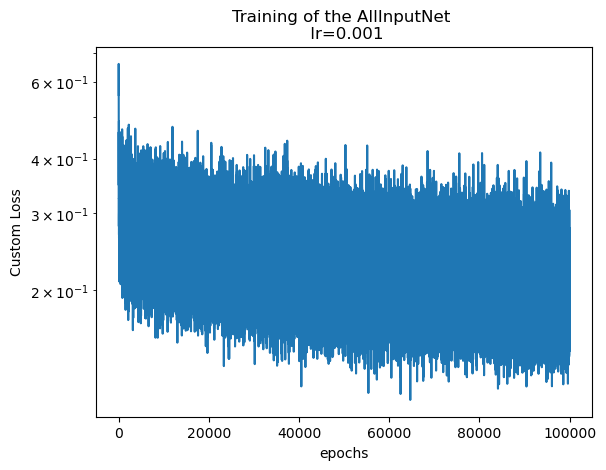

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1080.50it/s]


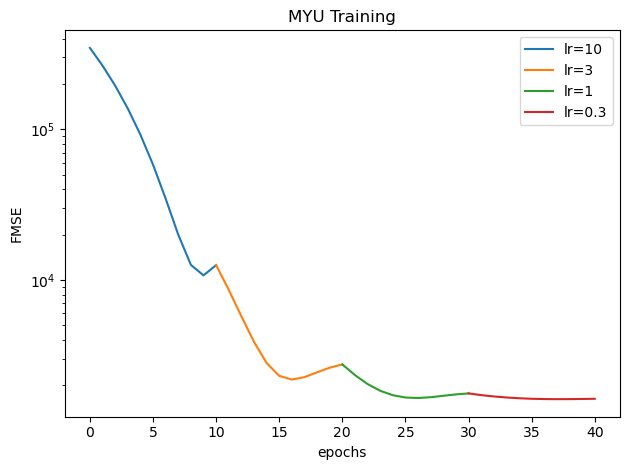

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

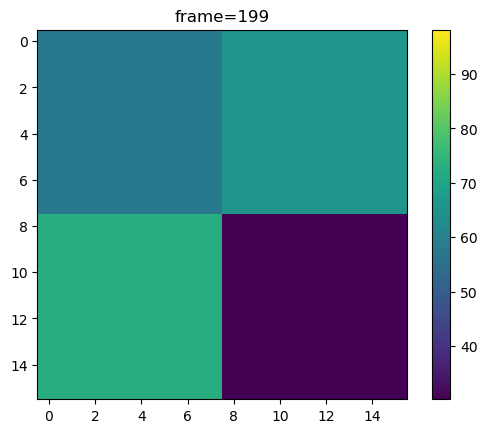

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

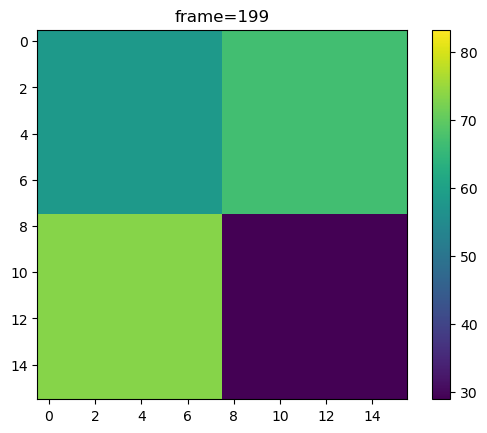

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.26it/s]


GIF successfully saved at full_analysis/allinputnet-N=16L=22-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=16L=22-test2-origin.gif!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 3015.50it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [25600 25600 25600 25600 25600 25600 25600 25600]
A.shape=(1, 200, 32, 32),
Myu.shape=(1, 200, 32, 32),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:31<00:00, 1091.99it/s]


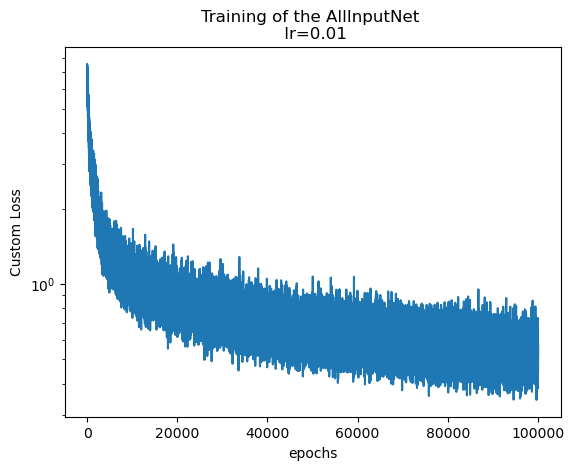

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:34<00:00, 1062.22it/s]


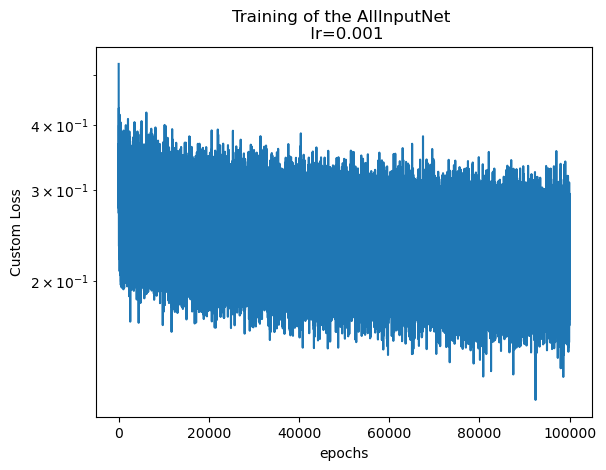

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 322.95it/s]


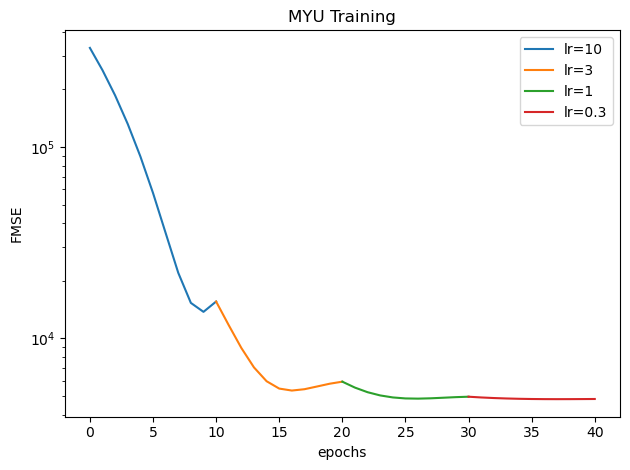

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

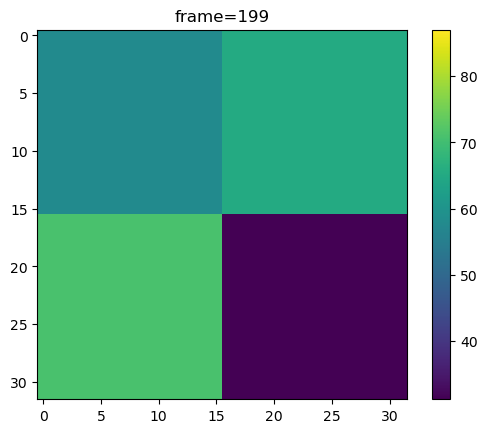

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

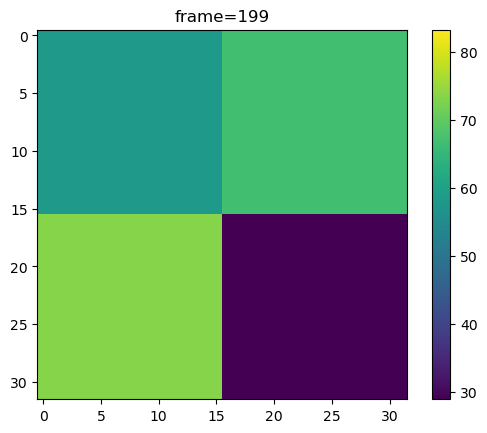

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 22.20it/s]


GIF successfully saved at full_analysis/allinputnet-N=32L=17-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=32L=17-test2-origin.gif!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4988.65it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [25600 25600 25600 25600 25600 25600 25600 25600]
A.shape=(1, 200, 32, 32),
Myu.shape=(1, 200, 32, 32),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:39<00:00, 1008.60it/s]


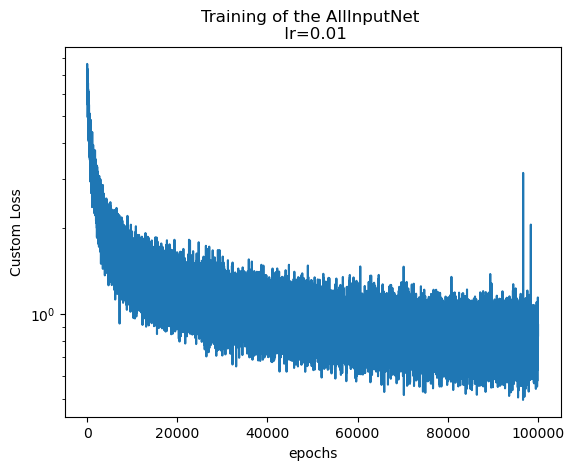

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:40<00:00, 992.24it/s]


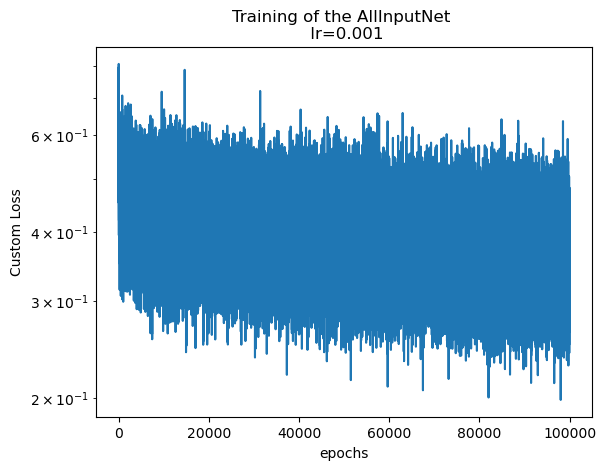

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 149.61it/s]


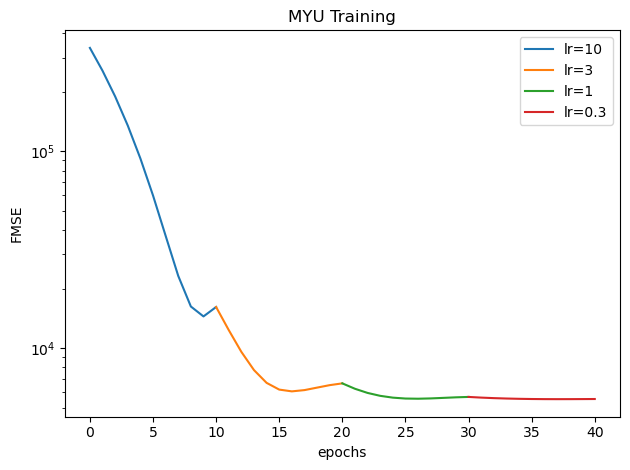

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

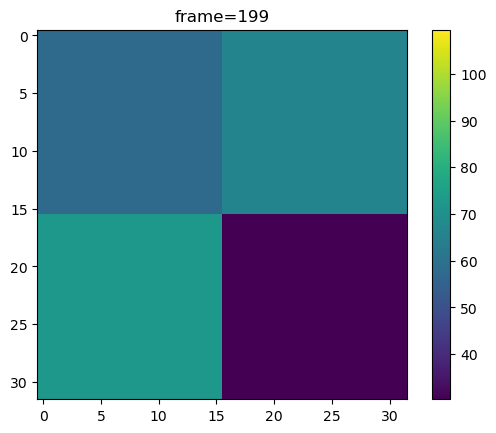

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

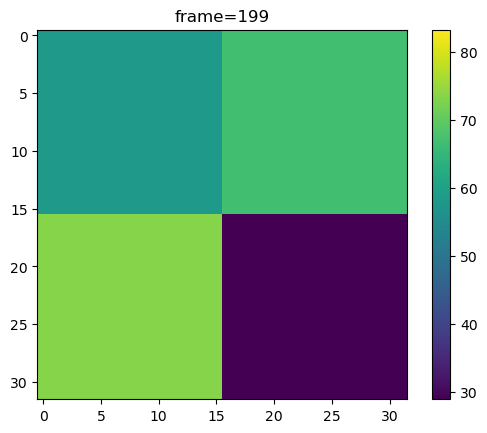

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.42it/s]


GIF successfully saved at full_analysis/allinputnet-N=32L=22-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=32L=22-test2-origin.gif!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4114.89it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [40000 40000 40000 40000 40000 40000 40000 40000]
A.shape=(1, 200, 40, 40),
Myu.shape=(1, 200, 40, 40),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:44<00:00, 956.69it/s]


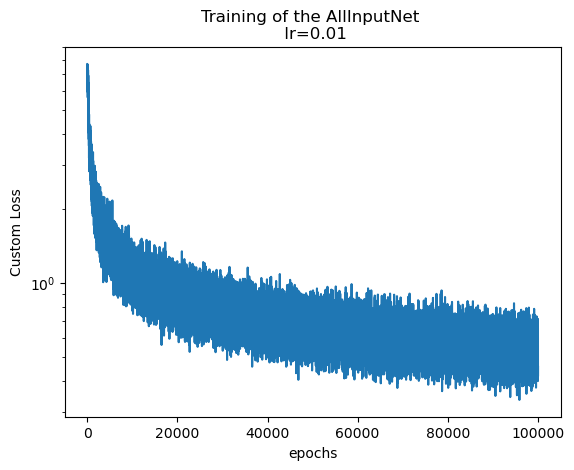

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:45<00:00, 945.82it/s]


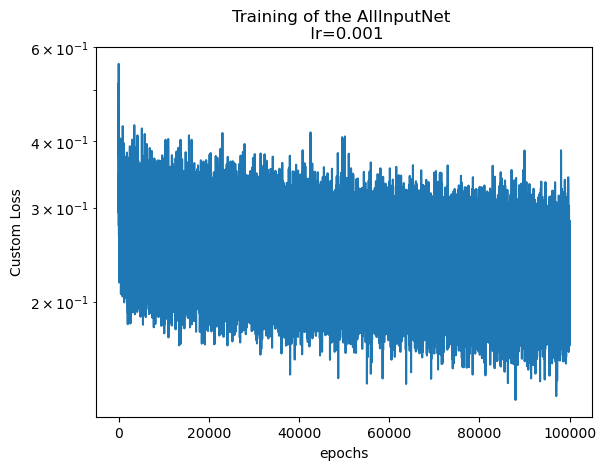

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 227.39it/s]


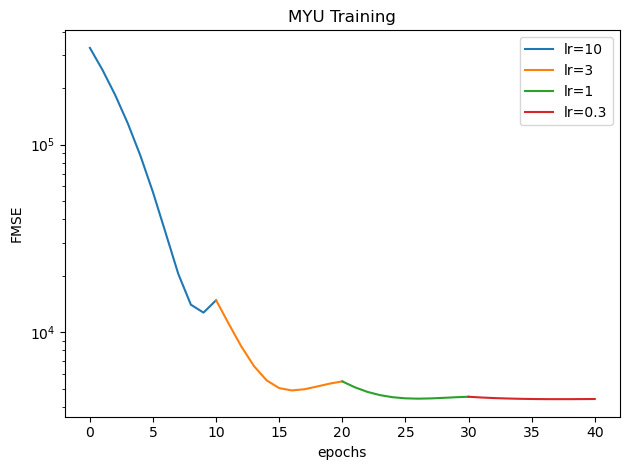

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

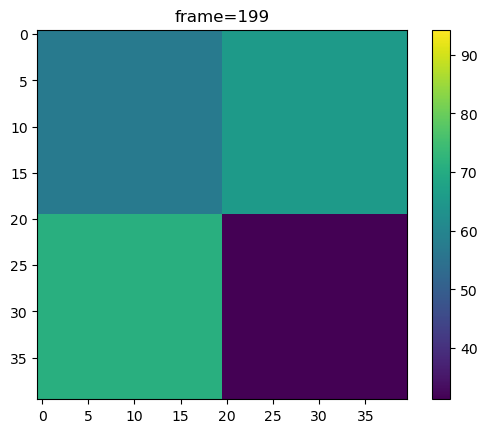

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

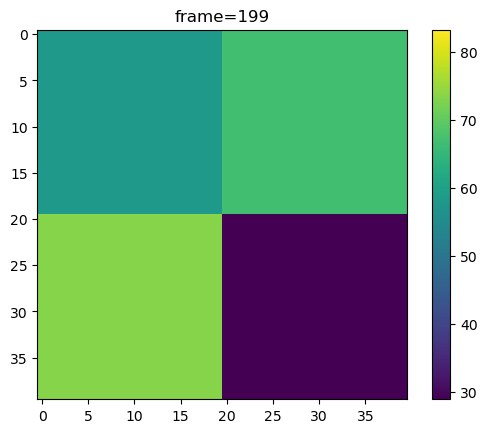

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 20.98it/s]


GIF successfully saved at full_analysis/allinputnet-N=40L=17-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=40L=17-test2-origin.gif!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 4009.28it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [40000 40000 40000 40000 40000 40000 40000 40000]
A.shape=(1, 200, 40, 40),
Myu.shape=(1, 200, 40, 40),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:35<00:00, 1044.65it/s]


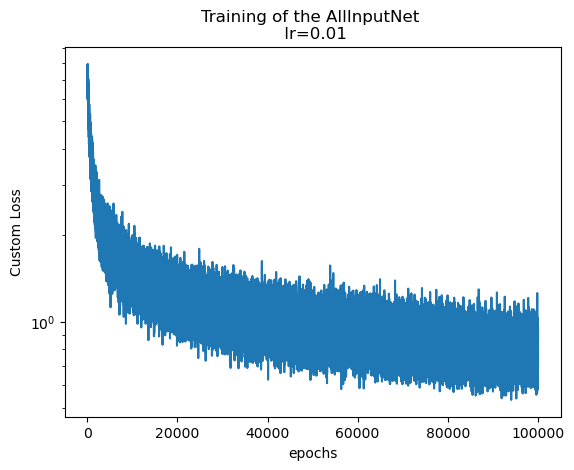

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:40<00:00, 992.01it/s]


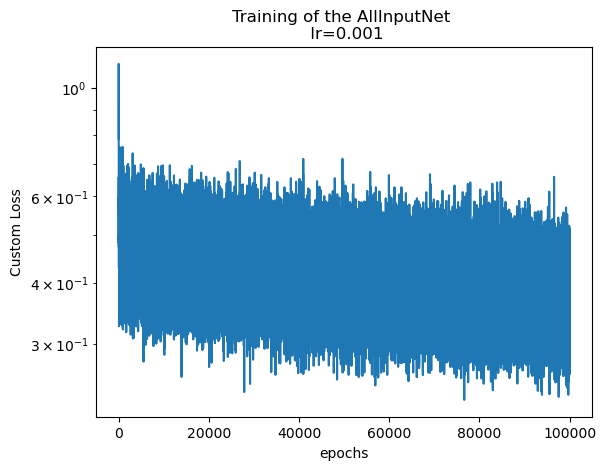

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 113.96it/s]


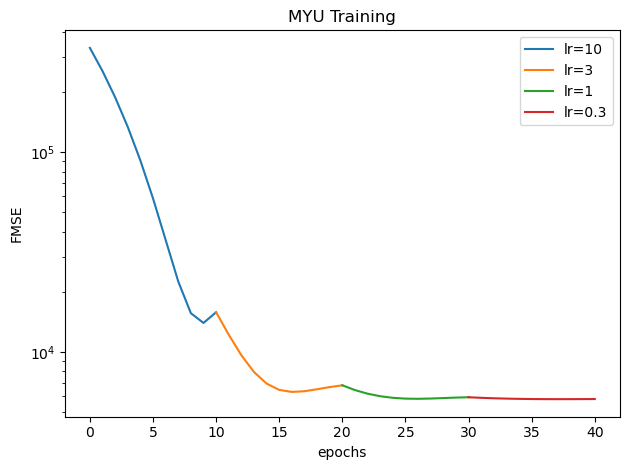

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

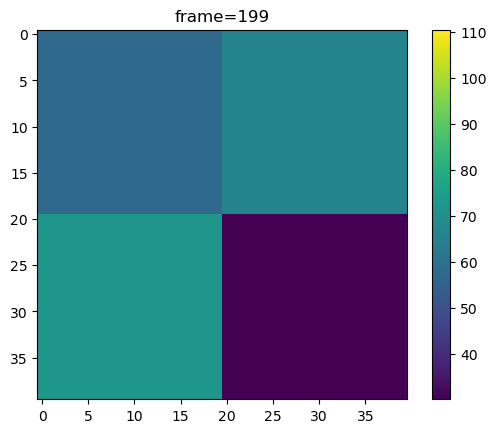

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

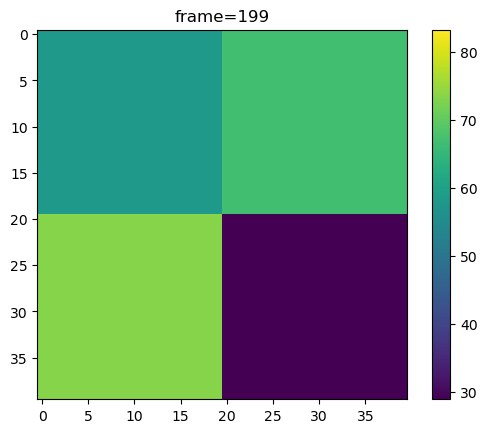

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.28it/s]


GIF successfully saved at full_analysis/allinputnet-N=40L=22-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=40L=22-test2-origin.gif!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 2278.51it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [102400 102400 102400 102400 102400 102400 102400 102400]
A.shape=(1, 200, 64, 64),
Myu.shape=(1, 200, 64, 64),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:35<00:00, 1051.16it/s]


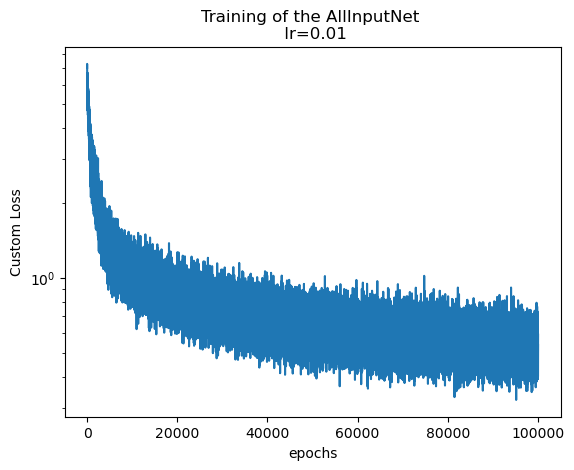

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:01<00:00, 819.81it/s]


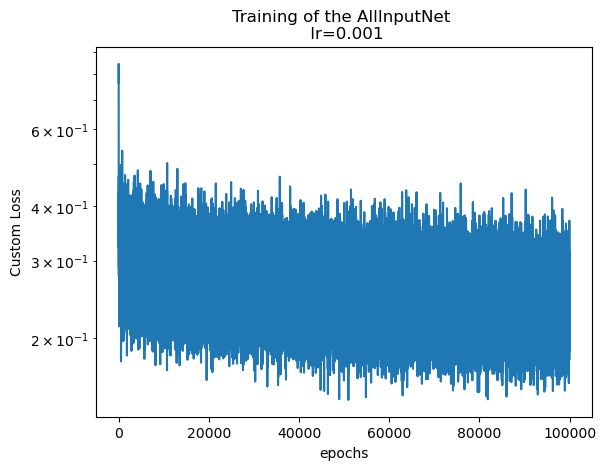

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.50it/s]


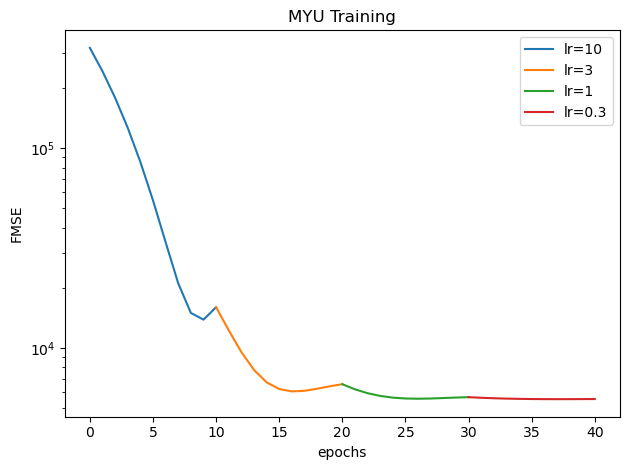

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

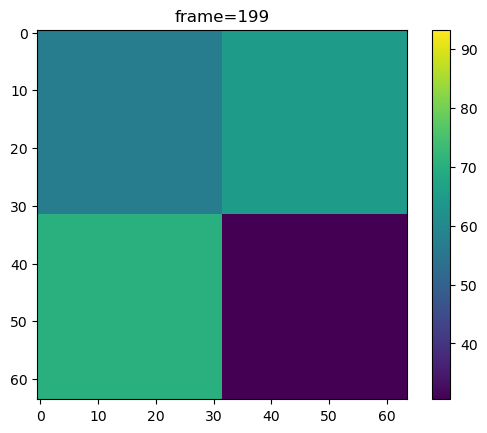

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

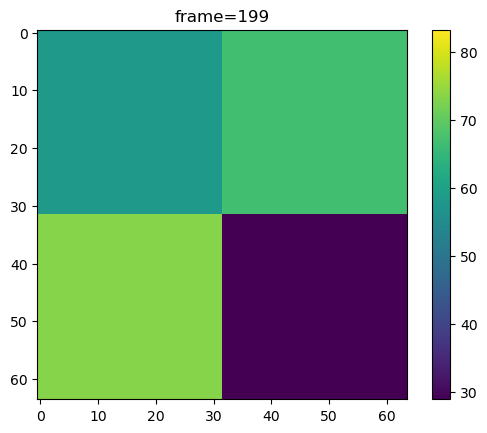

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:14<00:00, 14.27it/s]


GIF successfully saved at full_analysis/allinputnet-N=64L=17-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=64L=17-test2-origin.gif!


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1731.65it/s]


Unique Myus count	 8
Max value of myu:	 104.14104515595743
Min value of myu:	 28.893477672414097
Unique values: [28.893477672414097, 53.20229459360476, 58.10798245027815, 66.83168520679922, 73.33809836951713, 81.01192118026601, 85.93150003649163, 104.14104515595743]
Counts:		 [102400 102400 102400 102400 102400 102400 102400 102400]
A.shape=(1, 200, 64, 64),
Myu.shape=(1, 200, 64, 64),

Any NaN values in Myu		 False
Any NaN values in A_original	 False


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:37<00:00, 634.77it/s]


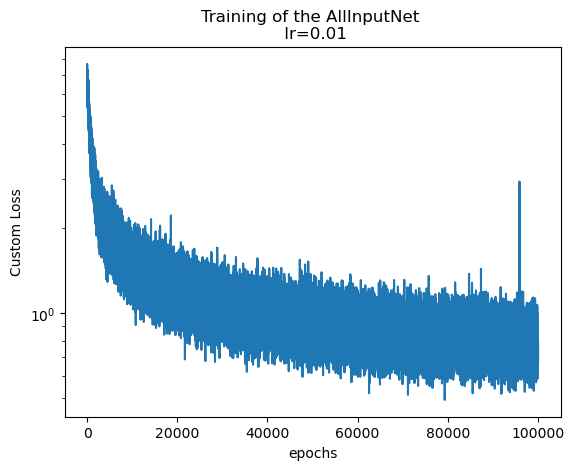

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:02<00:00, 815.03it/s]


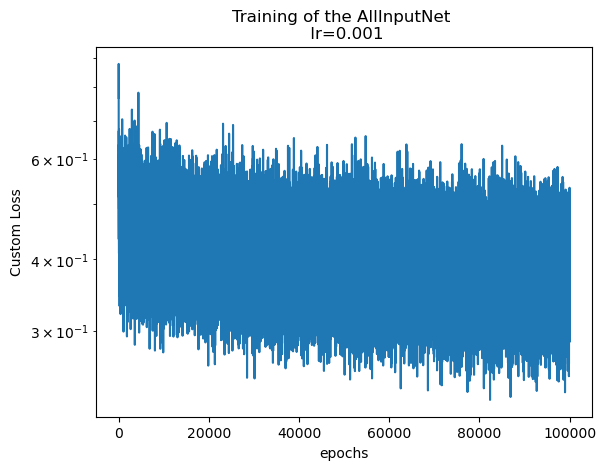

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 64.73it/s]


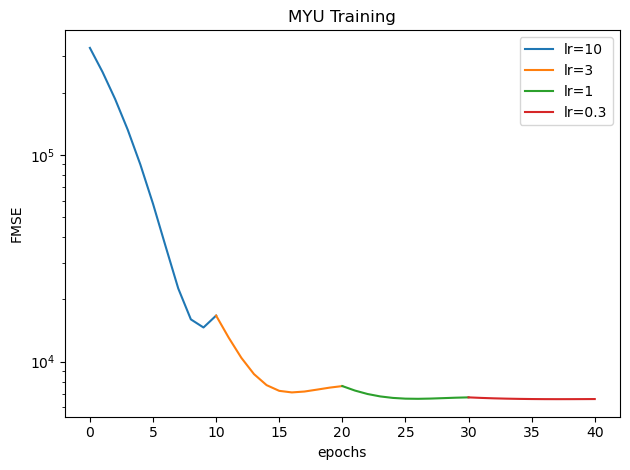

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

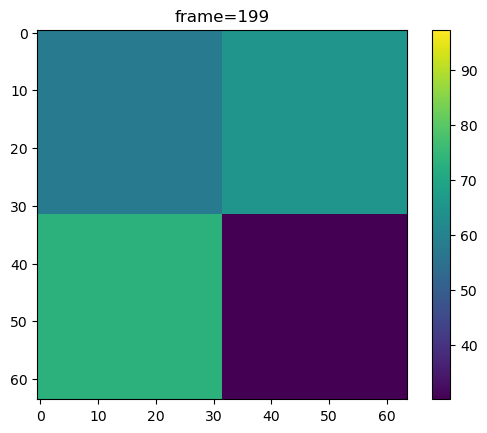

<Figure size 1400x1200 with 0 Axes>

<Figure size 1400x1200 with 0 Axes>

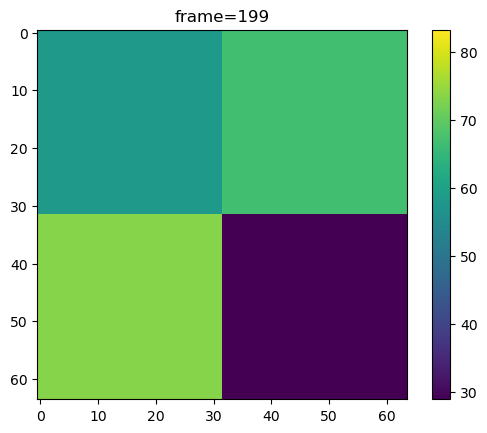

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:09<00:00, 21.60it/s]


GIF successfully saved at full_analysis/allinputnet-N=64L=22-test2-origin.gif
Total 100 frames in the gif full_analysis/allinputnet-N=64L=22-test2-origin.gif!


In [53]:
N = 64
L = 60
rangeN = [4,6,8,10,12,14,16,32,40,64]
rangeL = [5,8,10,15,17,20,22,25,30,40,60]

for N in rangeN:
    for L in rangeL:
        key = f"N={N}L={L}-test2"
        path = f"full_analysis/allinputnet-{key}-origin"
        mtlibpath_prefix =f"full_analysis/allinputnet-{key}-origin_mtl"
        if key in set(df['key']):
            continue
            
        Nx=N
        Ny=N

        Lx= L
        Ly= L
        T_end = 1
        dt = 0.005

        input_to_defect_ratio_sqrt = N//2
        N_ITERATIONS = int(T_end / dt)
        A_norm, A_original, mem_rate, myu_original = compute_A_norm(
            Nx=Nx, 
            Ny=Ny, 
            input_to_defect_ratio=input_to_defect_ratio_sqrt*input_to_defect_ratio_sqrt, 
            mean=5.4, 
            std_deviation=0.8, 
            time_period=25, 
            Lx=Lx, 
            Ly=Ly, 
            dt=dt, 
            T_End=T_end, 
            parallel_runs=1, 
            input_scale=0.75, 
            mem_coef=1, 
            time_period_parameter=100, 
            _mean=5.4, 
            std_deviation_run_computation=1,
            input_myu=None
        )


        x = np.linspace(0, Lx, Nx).flatten()[:, None] - Lx/2
        y = np.linspace(0, Ly, Ny).flatten()[:, None] - Ly/2
        t = np.linspace(0, T_end, N_ITERATIONS).flatten()[:, None]

        Exact = A_original.squeeze(0)

        X, T, Y = np.meshgrid(x, t, y)

        X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))
        u_star = Exact.flatten()
        u_star = np.hstack([u_star.real[:, None],u_star.imag[:, None]])

        torch.manual_seed(0)
        device = 'cpu'
        net = ALLINPUTPINN([3,8,32,64,32,8,2]).to(device)

        train()
        myutrain()
        plot()

        pred = net.predict(X_star)
        real = A_original.reshape(-1)        
        fmse = net.fmse().item()
        
        module = np.abs(pred-real)
        
        df = df.append(pd.DataFrame({"key":[key],"N":[N],"L":[L],"mse":[np.mean(module**2)],"rmse":[np.mean(module)],"fmse":[fmse]}))

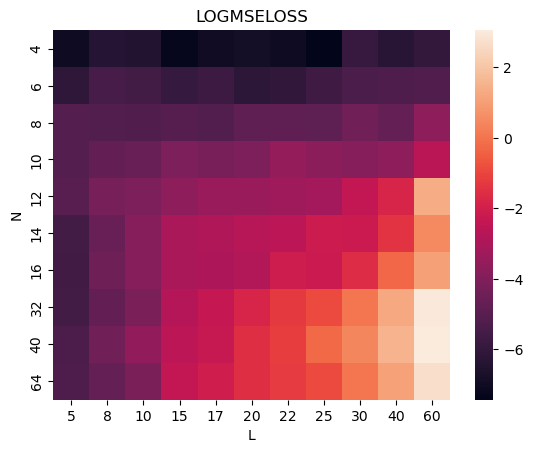

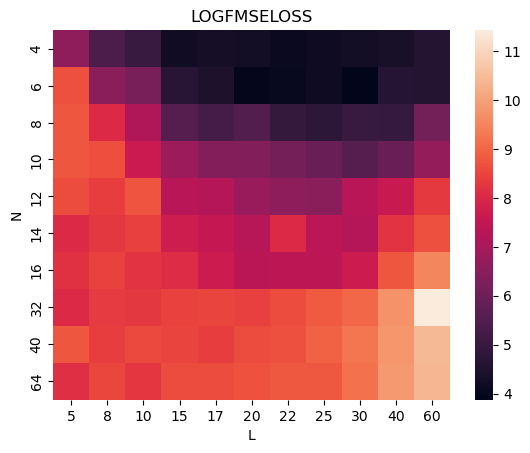

In [55]:
df = df.sort_values(by = ['N','L'])

yvals = rangeN
xvals = rangeL

zvals = np.log(np.array(np.array(df['mse'])).reshape(len(rangeN),len(rangeL)))
import seaborn as sns
s = sns.heatmap(zvals,xticklabels = xvals,yticklabels = yvals)
s.set(xlabel='L', ylabel = 'N',title = "LOGMSELOSS")
plt.savefig("LOGMSELOSS.png")
plt.show()

yvals = rangeN
xvals = rangeL

zvals = np.log(np.array(df['fmse']).reshape(len(rangeN),len(rangeL)))

s = sns.heatmap(zvals,xticklabels = xvals,yticklabels = yvals)
s.set(xlabel='L', ylabel = 'N',title = "LOGFMSELOSS")
plt.savefig("LOGFMSELOSS.png")
plt.show()


In [61]:
#df.to_csv("lossanalysis.csv",index = False)

In [62]:
#pd.read_csv("lossanalysis.csv")

,key,N,L,mse,rmse,fmse
0,N=4L=5-test2,4.0,5.0,0.000883,0.013092,732.162663
1,N=4L=8-test2,4.0,8.0,0.001709,0.016831,218.236467
2,N=4L=10-test2,4.0,10.0,0.001544,0.016810,150.543135
3,N=4L=15-test2,4.0,15.0,0.000691,0.012680,68.302350
4,N=4L=17-test2,4.0,17.0,0.000968,0.014461,73.058739
...,...,...,...,...,...,...
105,N=64L=22-test2,64.0,22.0,0.297151,0.380231,6583.671127
106,N=64L=25-test2,64.0,25.0,0.405333,0.442792,6604.360870
107,N=64L=30-test2,64.0,30.0,1.046998,0.724458,9735.313896
108,N=64L=40-test2,64.0,40.0,2.964781,1.181132,19052.203557
